<img src="data/Australia-facts-2.jpg" align="center">

The goal of this project is to predict the amount of rain that will fall in the next day in Australia. The dataset is from Kaggle and can be found [here](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). The dataset contains 10 years of daily weather observations from many locations across Australia. The data is from the Australian Bureau of Meteorology.

In [246]:
# All imports and settings used in the notebook

import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import missingno as mno
import matplotlib.pyplot as plt
import numpy as np
import re
import random
import xgboost as xgb
import math

from math import radians, cos, sin
from scipy.stats import normaltest
from IPython.display import Image
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from shapely.geometry import Point
from geopy.geocoders import Nominatim
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.model_selection import ValidationCurve


# Set options

pd.set_option('display.max_columns', 30)
sns.set()

## Data Extraction from Excel File

We obtain the dataset in a zip file. After extracting the zip file, it contains the dataset in an Excel file and file with description of the dataset. We use the `pandas` library to read the Excel file into a dataframe. After renaming the columns, we have the following dataframe, we store the dataframe in a Parquet file for future use.

In [247]:
!unzip -o data/australia_rain.zip -d data

Archive:  data/australia_rain.zip
  inflating: data/description.txt    
  inflating: data/australia_weather.xlsx  


In [248]:
# load data from excel file and store to parquet file

column_names = [
    'Date',
    'Location',
    'MinTemp',
    'MaxTemp',
    'Rainfall',
    'Evaporation',
    'Sunshine',
    'WindGustDir',
    'WindGustSpeed',
    'WindDir9am',
    'WindDir3pm',
    'WindSpeed9am',
    'WindSpeed3pm',
    'Humidity9am',
    'Humidity3pm',
    'Pressure9am',
    'Pressure3pm',
    'Cloud9am',
    'Cloud3pm',
    'Temp9am',
    'Temp3pm',
    'RainToday',
    'RISK_MM',
    'RainTomorrow',
]

df = pd.read_excel(
    io='data/australia_weather.xlsx',
    sheet_name='Sheet1',
    header=None,
    names=column_names,
    index_col=None,
    usecols="C:Z",
    skiprows=10,
    nrows=156412,
)

In [249]:
df = df.rename(columns={
    'Rainfall': 'PrecipitationToday', 
    'RISK_MM': 'PrecipitationTomorrow'
})
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'PrecipitationToday',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'PrecipitationTomorrow',
       'RainTomorrow'],
      dtype='object')

In [250]:
df.to_parquet('data/australia_weather.parquet')

# 2. Exploratory Data Analysis

In this section we explore the data in order to get a better understanding of the dataset so that we can make better decisions when we are cleaning the data.

In [251]:
df = pd.read_parquet('data/australia_weather.parquet')

Before examining the dataset we make sure to first split the dataset into training and testing sets. We do this to avoid leaking any data from the test set - we only explore the data in the training set. We use the `train_test_split` function from the `sklearn` library to split the dataset into 80% training and 20% testing. 

In [252]:
train, test = train_test_split(df, test_size=0.2, random_state=0)

In [253]:
numeric_features = train.select_dtypes(include=["float64"])
cat_features = train.select_dtypes(include=["object"])

### Values in the dataset

Mostly real numbers. The rest is date and categorical data.

In [254]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125129 entries, 68012 to 43567
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   125129 non-null  object 
 1   Location               125129 non-null  object 
 2   MinTemp                124572 non-null  float64
 3   MaxTemp                124858 non-null  float64
 4   PrecipitationToday     123898 non-null  float64
 5   Evaporation            71591 non-null   float64
 6   Sunshine               65459 non-null   float64
 7   WindGustDir            116896 non-null  object 
 8   WindGustSpeed          116953 non-null  float64
 9   WindDir9am             116366 non-null  object 
 10  WindDir3pm             121787 non-null  object 
 11  WindSpeed9am           123923 non-null  float64
 12  WindSpeed3pm           122792 non-null  float64
 13  Humidity9am            123586 non-null  float64
 14  Humidity3pm            121943 non

### Problems with the data

#### Duplicates

We check for duplicates in the dataset. We find that there are quite a few duplicates. We remove the duplicates from the dataset to avoid skewing the EDA.

In [255]:
# Count of duplicated rows
train.loc[train.duplicated()].shape

(9148, 24)

In [256]:
train.drop_duplicates(inplace=True)

#### Missing values

4 features are missing over 40% - 50% rows, other 5 are missing 6% - 10% rows and the rest have below 3% of missing rows.

<Axes: >

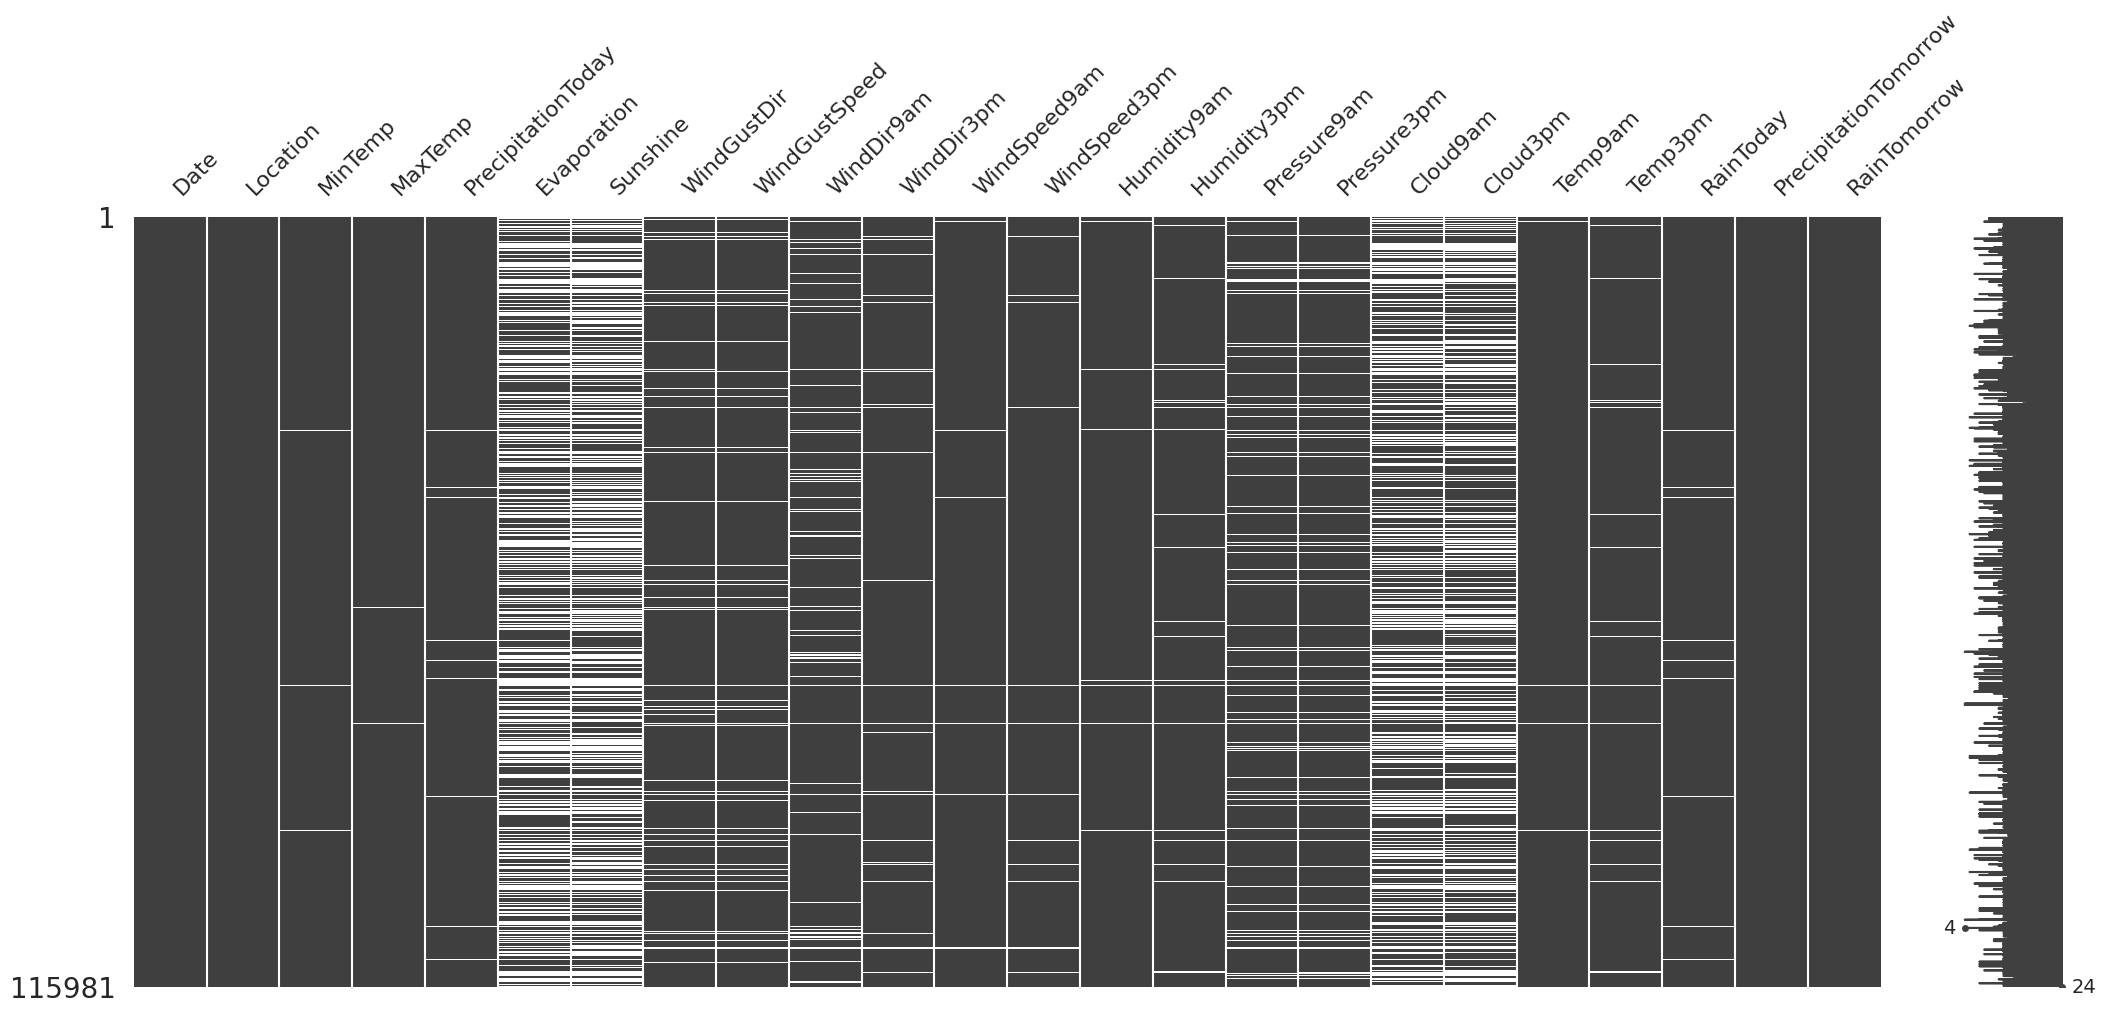

In [257]:
mno.matrix(train.sort_values(by='Date'))

In [258]:
# percentages of missing values

null_percentages = (train.isna().sum() / len(train) * 100)
keep_columns = null_percentages[null_percentages > 0]
pd.Series.sort_values(keep_columns, ascending=False).map(lambda x: f'{x:.2f}%')

Sunshine              47.69%
Evaporation           42.78%
Cloud3pm              40.14%
Cloud9am              37.72%
Pressure9am            9.87%
Pressure3pm            9.85%
WindDir9am             7.02%
WindGustDir            6.57%
WindGustSpeed          6.53%
WindDir3pm             2.67%
Humidity3pm            2.53%
Temp3pm                1.90%
WindSpeed3pm           1.85%
Humidity9am            1.24%
RainToday              0.99%
PrecipitationToday     0.99%
WindSpeed9am           0.96%
Temp9am                0.62%
MinTemp                0.45%
MaxTemp                0.22%
dtype: object

#### Outliers

Pressure has extreme outliers. We noticed that it might be an error in units, so we fix it in preprocessing.

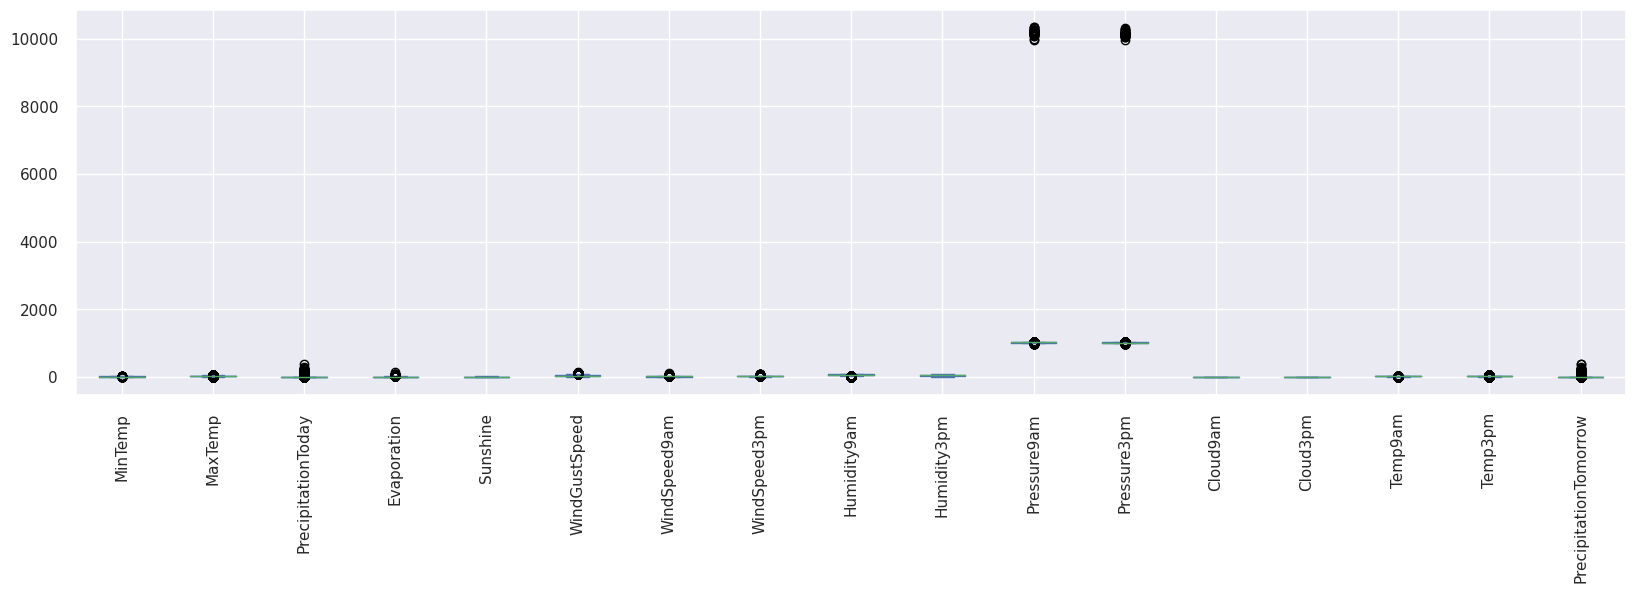

In [259]:
# outliers

numeric_features.plot(figsize=(20, 5), kind="box", rot=90)
plt.show()

Below we visualize the box plots again, however, this time we remove the `Pressure*` and `Precipitation*` features, which have significant outliers. We can see that the other features have outliers, but they are not extreme for most of the features. The features that do have significant outliers are Wind speed and Evaporation. We will deal with all outliers in the preprocessing step.

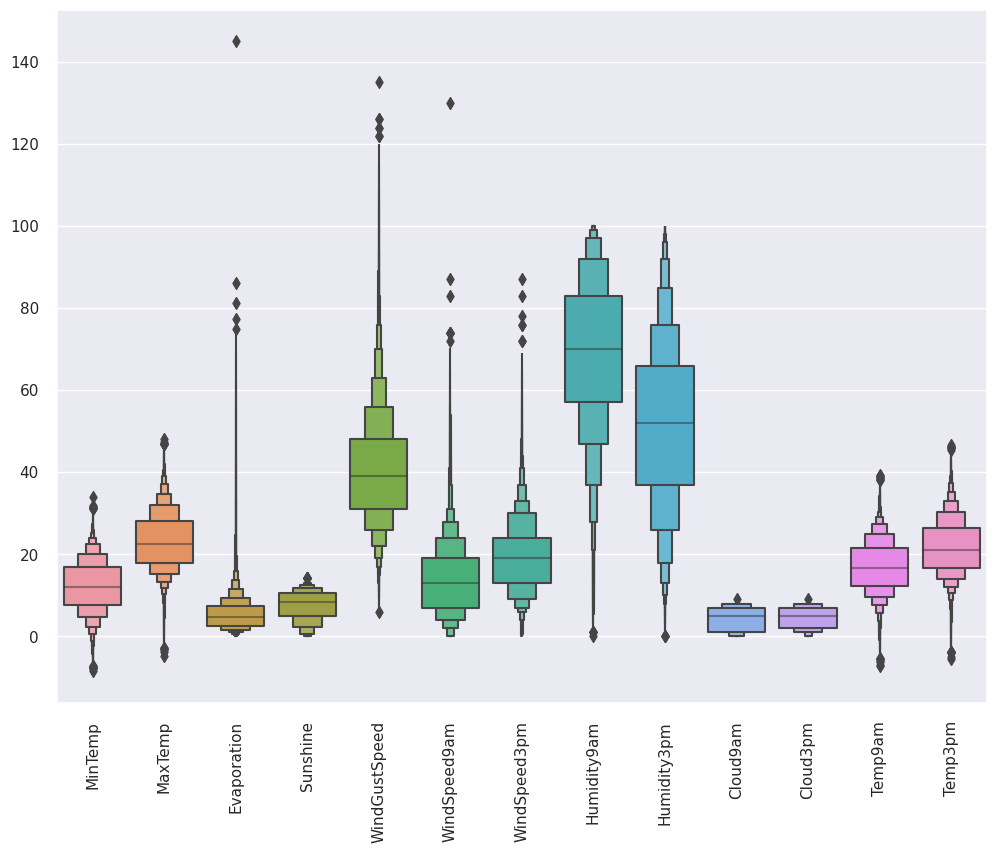

In [260]:
without_pressure = numeric_features.drop(columns=[
    "Pressure9am", "Pressure3pm",
    "PrecipitationToday", "PrecipitationTomorrow"
    ])
plt.xticks(rotation=90)
sns.boxenplot(without_pressure)
plt.show()

### Data distributions

According to histograms, we can assume that Temperature, Humidity, Wind speed, Sunshine and Pressure(without outliers) have normal distributions. For the remaining features it's more difficult to assume, because outliers distort the graphs.

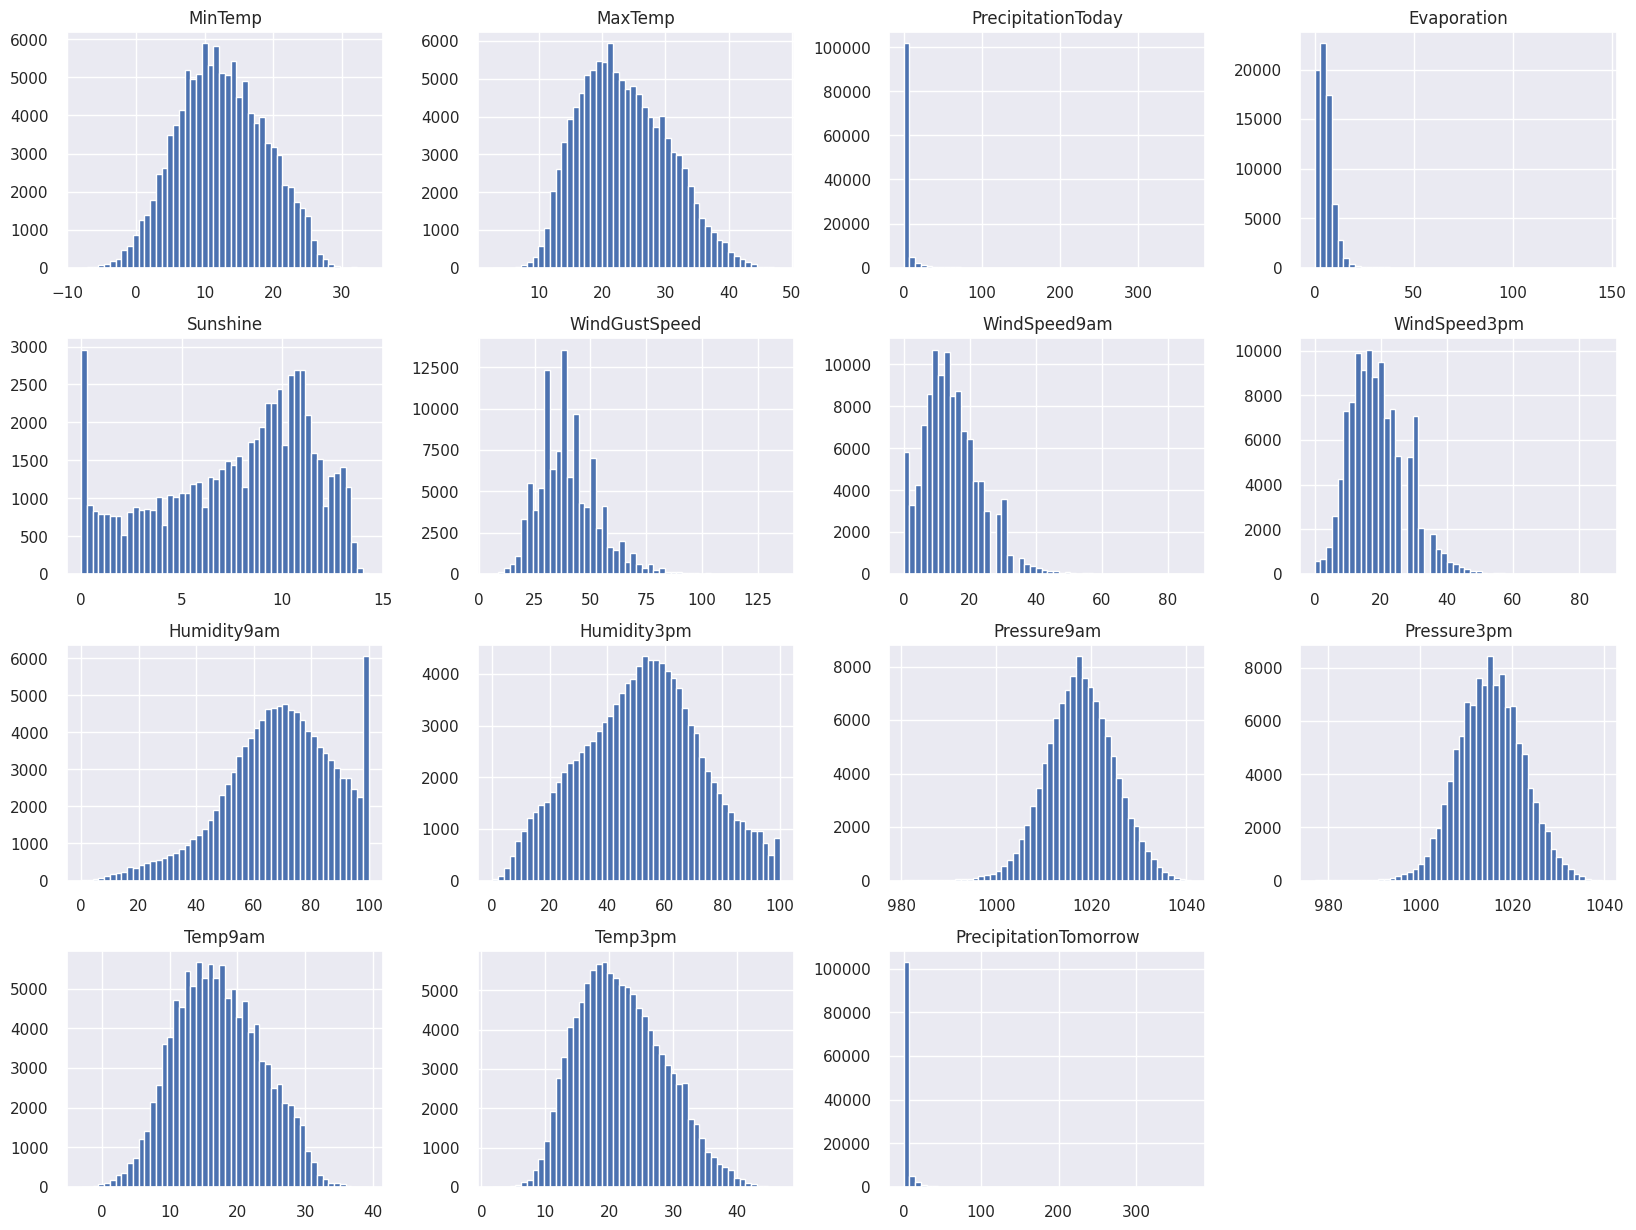

In [261]:
# distributions of numeric columns
# Cloud features are numeric but behave as categorical with discrete values from 0 to 8
numeric_features = numeric_features.query("Pressure9am < 5000").query("Pressure3pm < 5000")
numeric_without_cloud = numeric_features.drop(columns=["Cloud9am", "Cloud3pm"])
numeric_without_cloud.hist(figsize=(20, 15), bins=50)
plt.show()

According to the normal test, each feature have p-value less than 0.00, therefore we can reject the null hypothesis and assume that all features have normal distributions. For the features with significant outliers, we can see that z-scores are high and therefore the graphs were skewed.

In [262]:
print('%22s  %10s  %s' % ("Column", "Statistic", "P value"))
print("-------------------------------------------------")
for column in numeric_without_cloud:
    stat, p_val = normaltest(numeric_without_cloud[column], nan_policy="omit")
    print('%22s  %10.2f  %.2f' % (column, stat, p_val))

                Column   Statistic  P value
-------------------------------------------------
               MinTemp     2453.50  0.00
               MaxTemp     4098.35  0.00
    PrecipitationToday   172361.59  0.00
           Evaporation    63190.60  0.00
              Sunshine     8625.03  0.00
         WindGustSpeed    13878.21  0.00
          WindSpeed9am    10954.71  0.00
          WindSpeed3pm     7921.16  0.00
           Humidity9am     3998.57  0.00
           Humidity3pm     2407.37  0.00
           Pressure9am      385.14  0.00
           Pressure3pm      101.20  0.00
               Temp9am     2540.41  0.00
               Temp3pm     3346.52  0.00
 PrecipitationTomorrow   179502.14  0.00


### Relationships in the data

Significant positive correlations: Evaporation and Temperature, Sunshine and Temperature, Sunshine and Evaporation, Clouds and Humidity. 

Significant negative correlations: Humidity and Temperature, Pressure and Temperature, Pressure and Wind speed, Humidity and Sunshine, Humidity and Evaporation, Clouds and Sunshine.

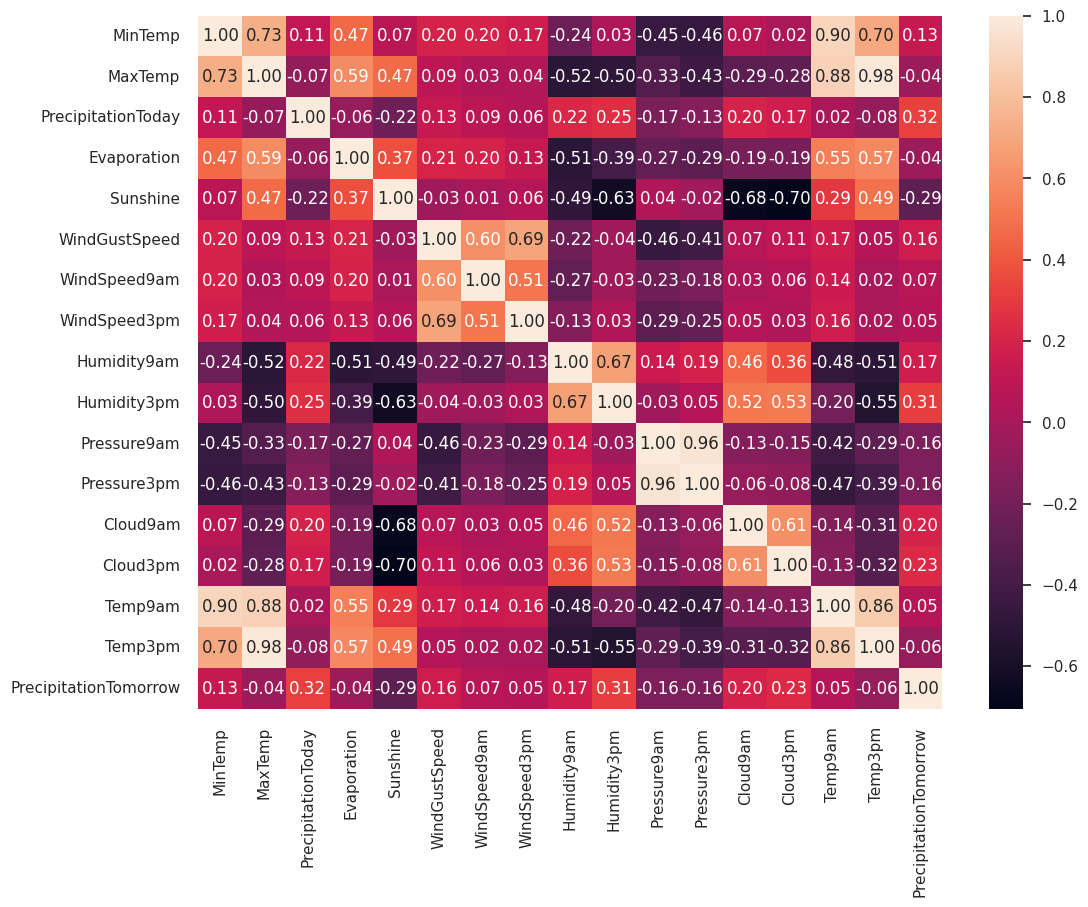

In [263]:
# correlation matrix

sns.set(rc={'figure.figsize':(12,9)})
sns.heatmap(numeric_features.corr(numeric_only=True), annot=True, fmt=".2f")
plt.show()

### Location and Wind

**Assumption**: Precipitation depends on specific location and wind speed/dir combination.

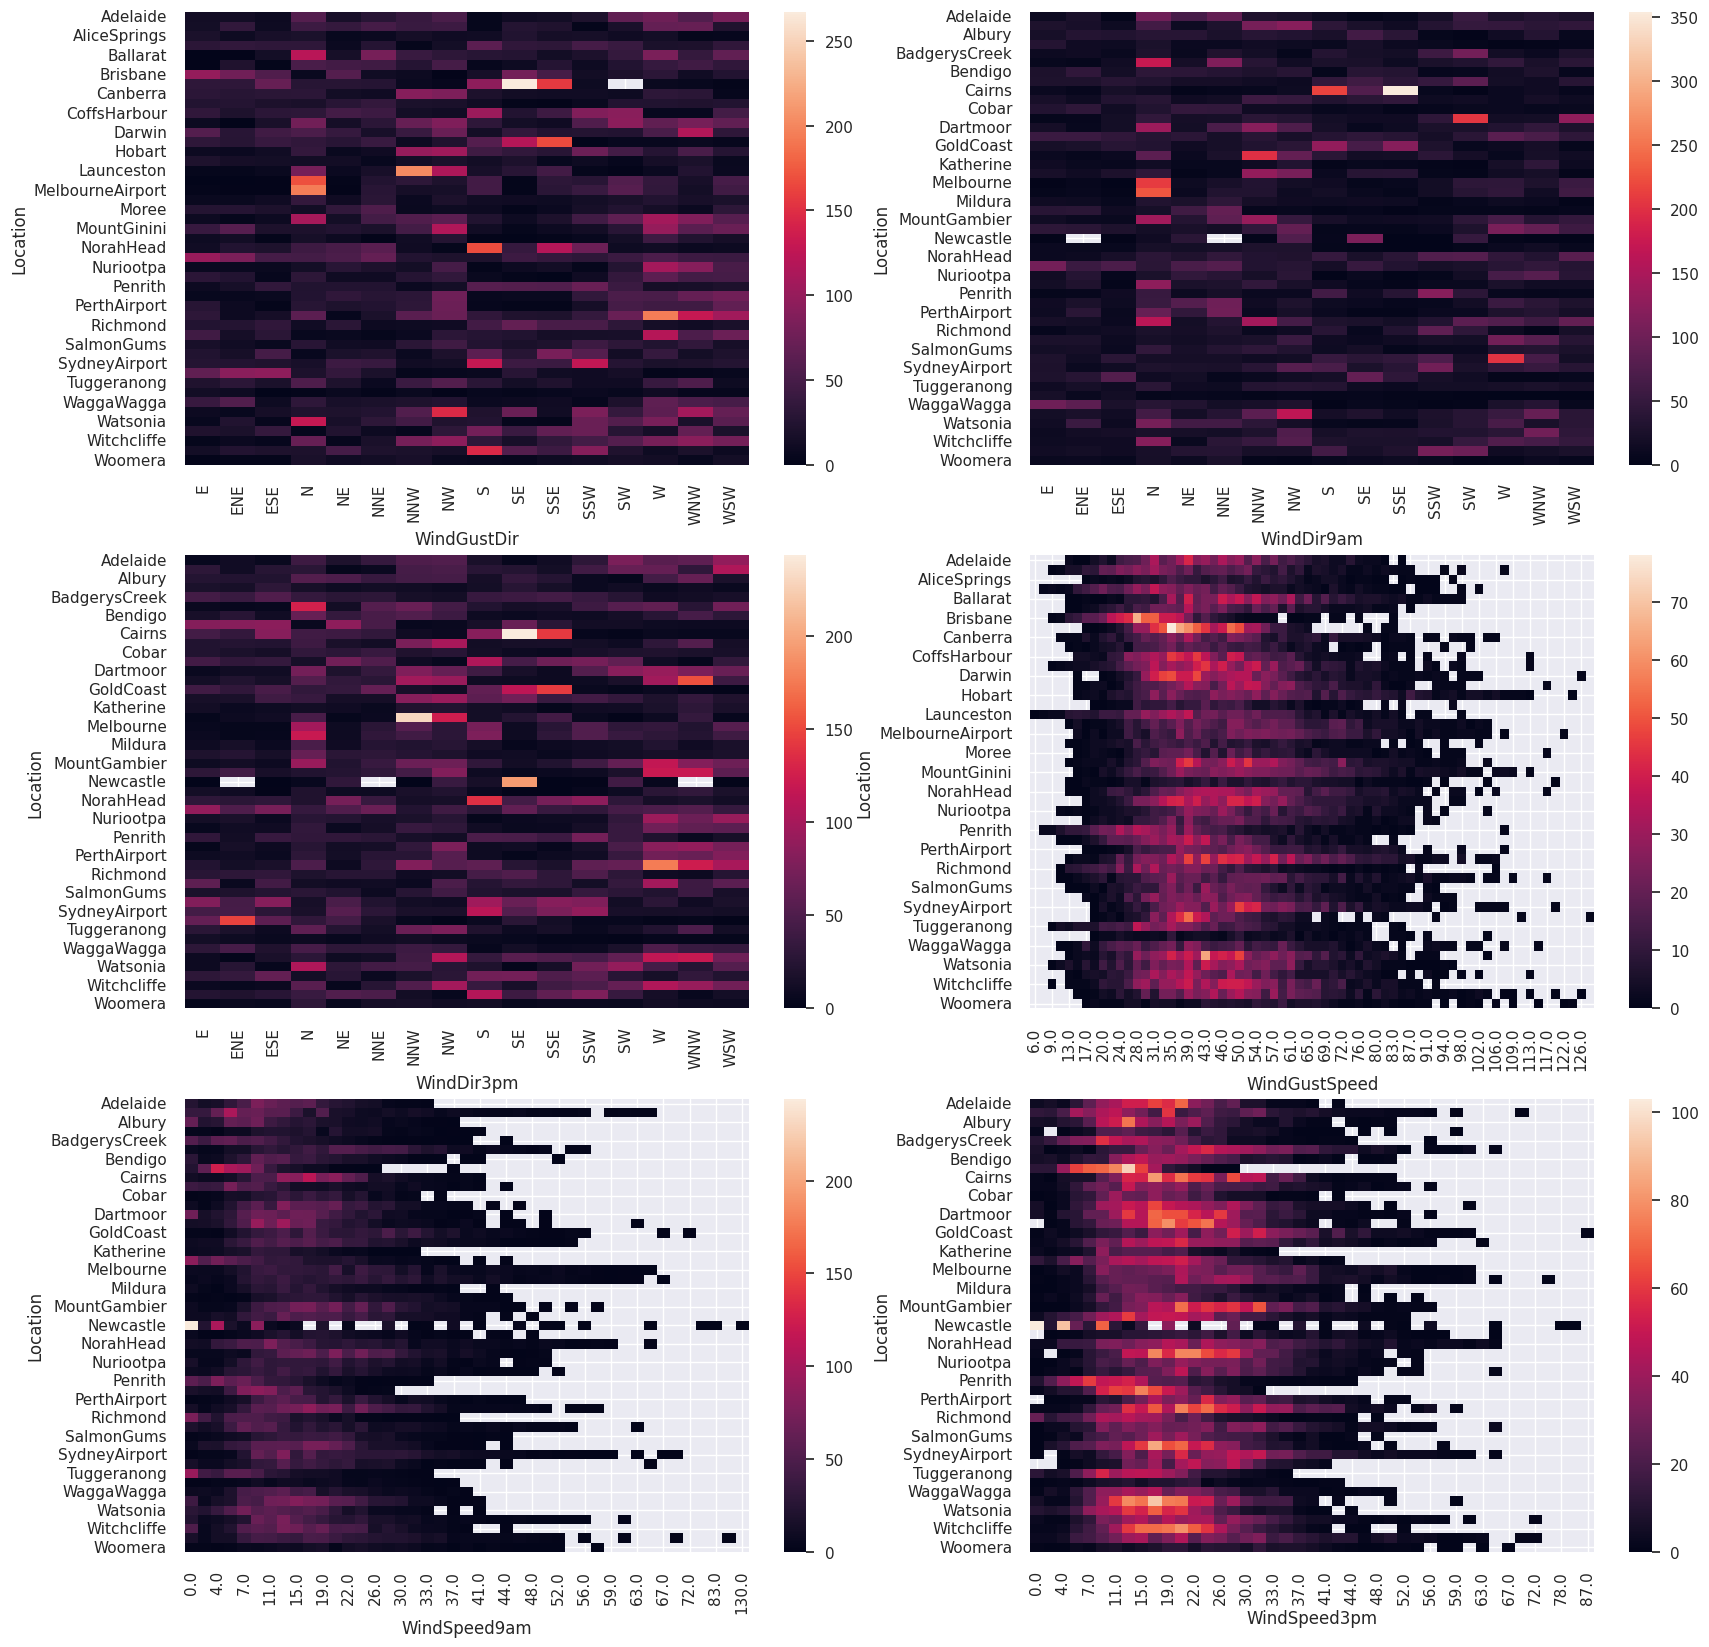

In [264]:
train["RainTomorrowBool"] = train.RainTomorrow == "Yes"
locWindDir = train[["Location", "WindGustDir", "RainTomorrowBool"]].pivot_table(index="Location", columns="WindGustDir", values='RainTomorrowBool', aggfunc='sum')
locWindDir9am = train[["Location", "WindDir9am", "RainTomorrowBool"]].pivot_table(index="Location", columns="WindDir9am", values='RainTomorrowBool', aggfunc='sum')
locWindDir3pm = train[["Location", "WindDir3pm", "RainTomorrowBool"]].pivot_table(index="Location", columns="WindDir3pm", values='RainTomorrowBool', aggfunc='sum')
locWindSpeed = train[["Location", "WindGustSpeed", "RainTomorrowBool"]].pivot_table(index="Location", columns="WindGustSpeed", values='RainTomorrowBool', aggfunc='sum')
locWindSpeed9am = train[["Location", "WindSpeed9am", "RainTomorrowBool"]].pivot_table(index="Location", columns="WindSpeed9am", values='RainTomorrowBool', aggfunc='sum')
locWindSpeed3pm = train[["Location", "WindSpeed3pm", "RainTomorrowBool"]].pivot_table(index="Location", columns="WindSpeed3pm", values='RainTomorrowBool', aggfunc='sum')
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
sns.heatmap(locWindDir, ax=axes[0][0])
sns.heatmap(locWindDir9am, ax=axes[0][1])
sns.heatmap(locWindDir3pm, ax=axes[1][0])
sns.heatmap(locWindSpeed, ax=axes[1][1])
sns.heatmap(locWindSpeed9am, ax=axes[2][0])
sns.heatmap(locWindSpeed3pm, ax=axes[2][1])
plt.show()

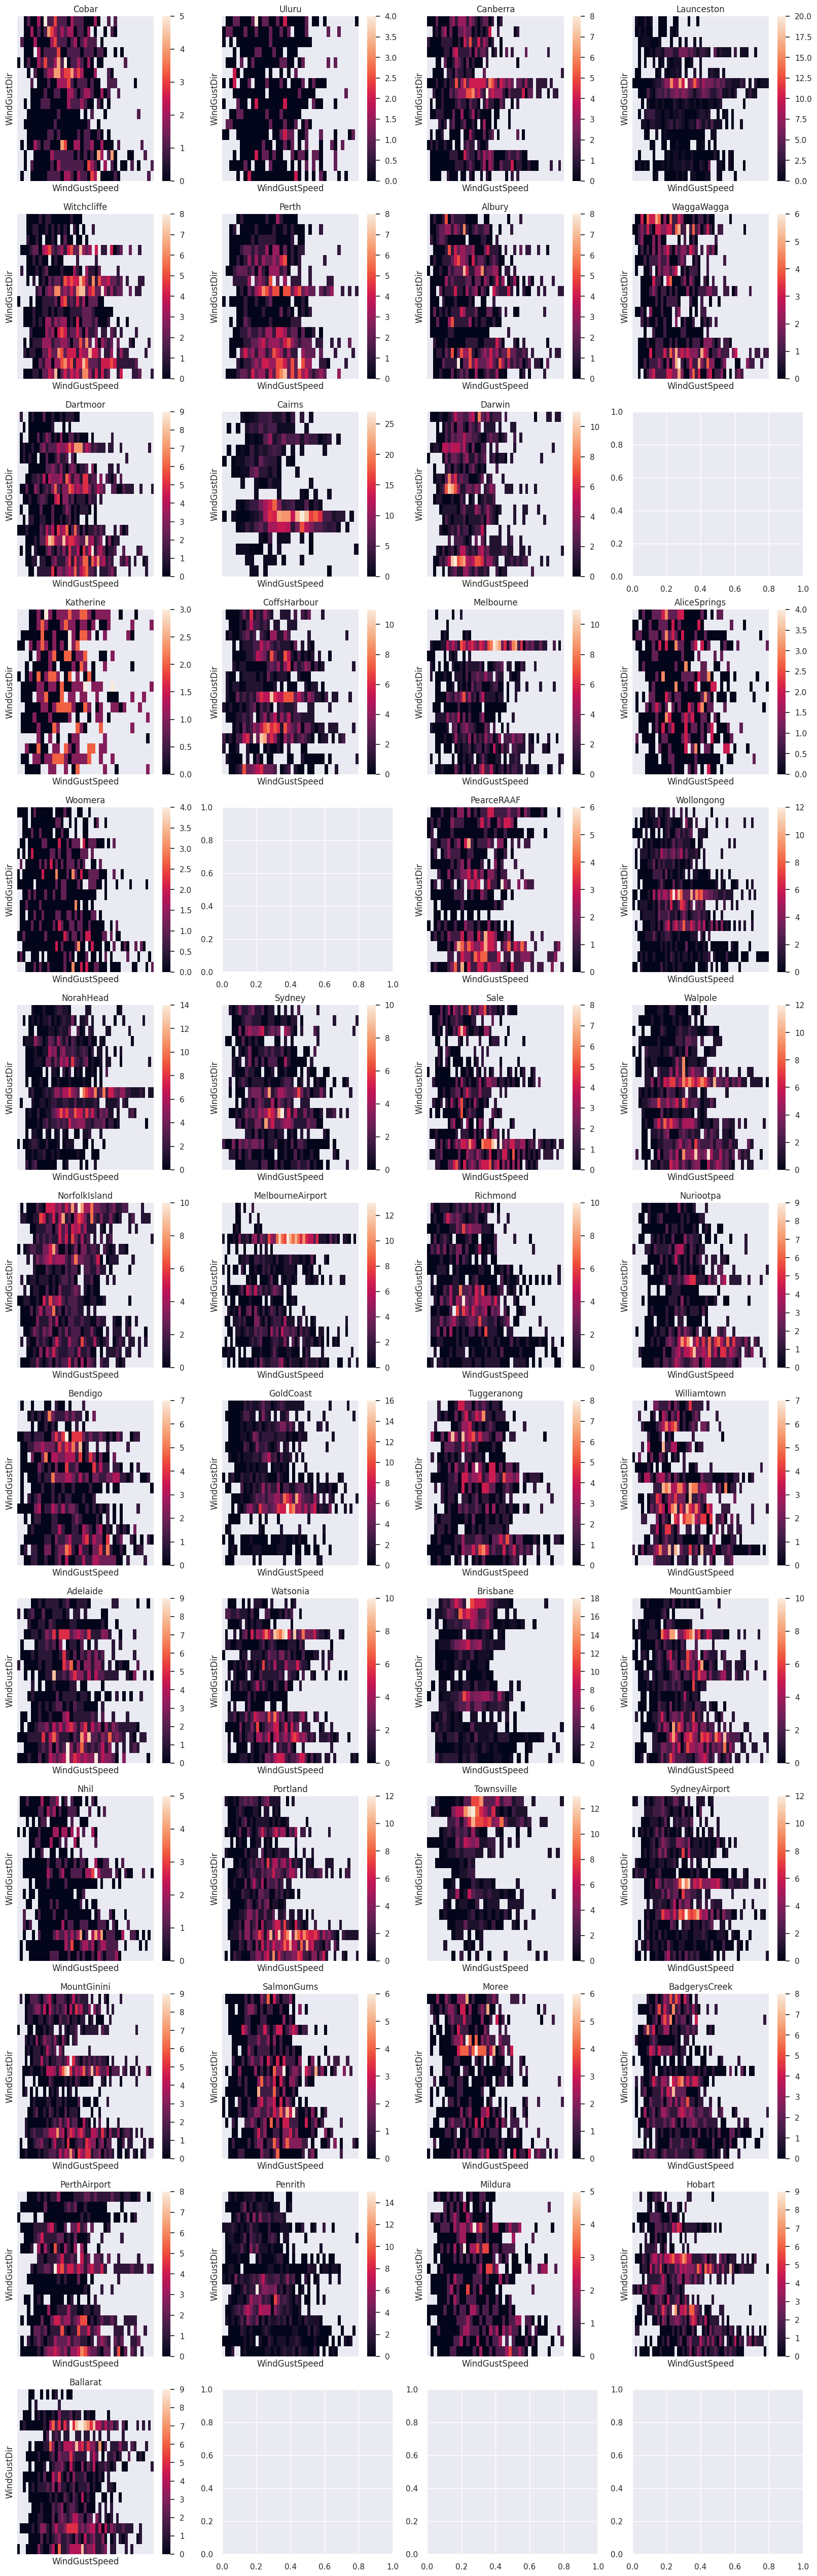

In [265]:
locations = train.Location.unique()
loc_len = len(locations)
rows, cols = math.ceil(loc_len / 4), 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))

for idx, loc in enumerate(locations):
    data = train[train.Location == loc][["WindGustDir", "WindGustSpeed", "RainTomorrowBool"]]
    pt = data.pivot_table(index="WindGustDir", columns="WindGustSpeed", values='RainTomorrowBool', aggfunc='sum')
    try:
        ax = axes.flat[idx]
        sns.heatmap(pt, ax=ax, xticklabels=False, yticklabels=False)
        ax.set_title(loc)
    except ValueError:
        pass
plt.show()

**Conclusion**: It seems that each location has specific combinations of wind speed and wind direction that result in higher probability of rain the next day.

## Location and Month

**Assumption**: Precipitation depends on specific location and month combination.

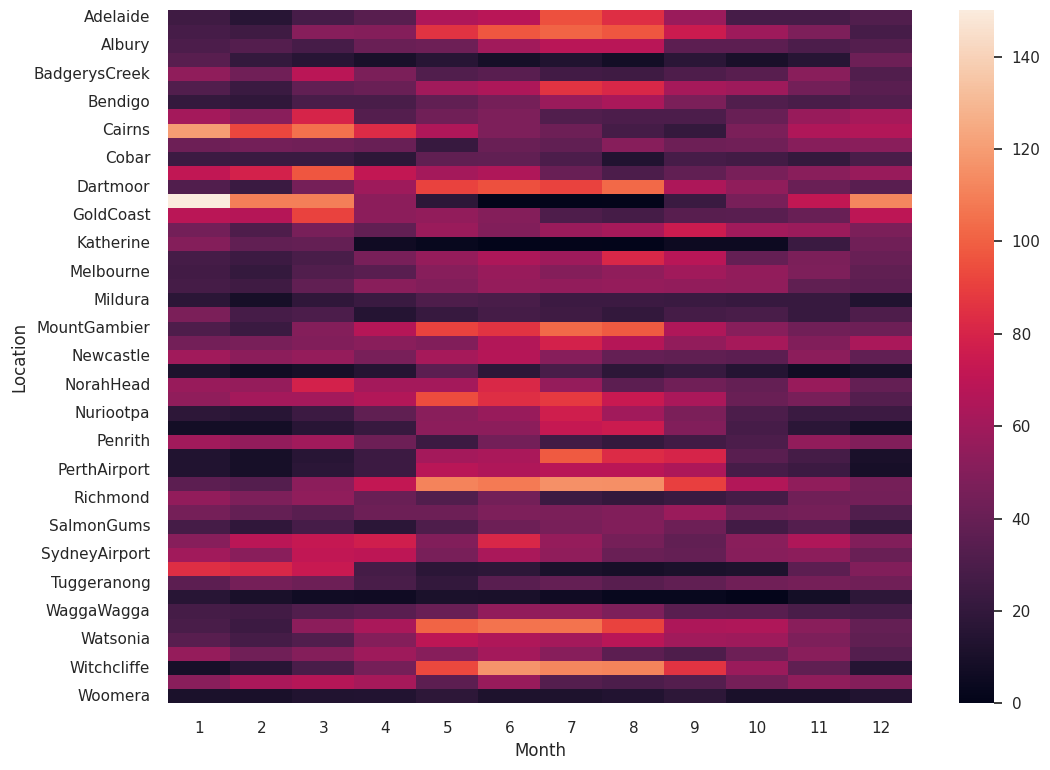

In [266]:
train['Date'] = pd.to_datetime(train['Date'], format='%d/%m/%Y')
train["Month"] = train.Date.dt.month

locMonth = train[["Location", "Month", "RainTomorrowBool"]].pivot_table(index="Location", columns="Month", values='RainTomorrowBool', aggfunc='sum')
sns.heatmap(locMonth)
plt.show()

**Conclusion**: It seems that each location has specific months that result in higher probability of rain the next day.

### Other observations

We plot the amount of data points for each year. We can see that the amount of data points for each year is roughly the same.

[]

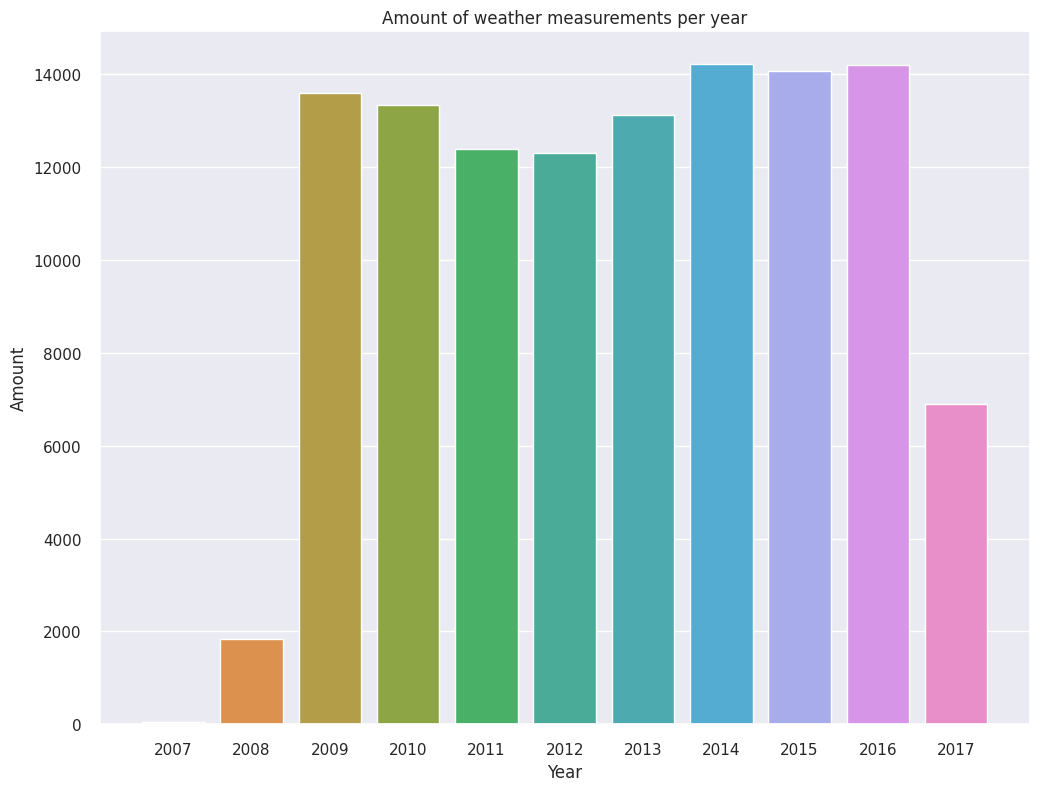

In [267]:
train['Date'] = pd.to_datetime(train['Date'], format='%d/%m/%Y')
year_counts = train.Date.dt.year.value_counts().sort_index()

ax = sns.barplot(x=year_counts.index, y=year_counts.values)

ax.set_title("Amount of weather measurements per year")
ax.set_xlabel("Year")
ax.set_ylabel("Amount")

ax.plot()

# Preprocessing

In this section we clean up the data and prepare it for the machine learning models. We will deal with the missing values and outliers. We will also encode the categorical features.

In [268]:
# Load dataset

df = pd.read_parquet("data/australia_weather.parquet")

In [269]:
# Drop all duplicate rows to avoid skewing the data

df.drop_duplicates(inplace=True)

In [270]:
# Keep only rows with defined prediction values

df = df[df['PrecipitationTomorrow'].notna()]

In [271]:
# Add month as a feature
# We do this because we want to see if there is a correlation between the month and the amount of rain

df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df["Month"] = df.Date.dt.month_name()

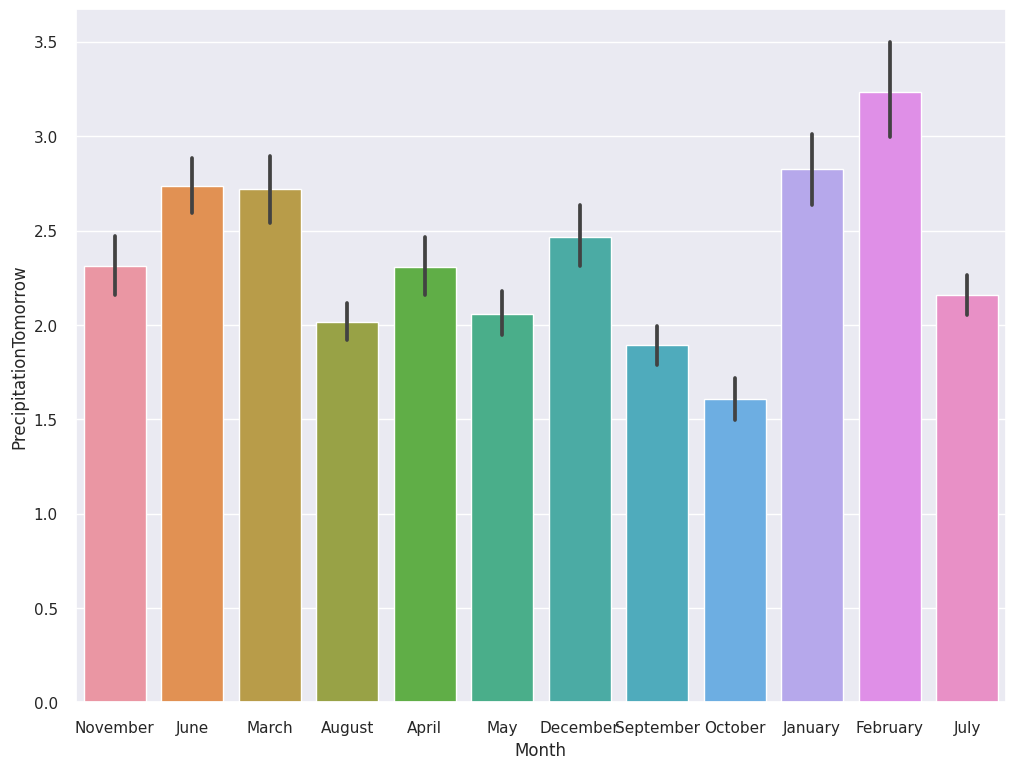

In [272]:
# Graph the amount of rain per month

sns.set(rc={'figure.figsize':(12,9)})
sns.barplot(x=df.Month, y=df.PrecipitationTomorrow)
plt.show()

In [273]:
# Pressure outliers are order of magnitude higher than the rest. 
# We assume that it was a systematic error and we scale them down.

df['Pressure3pm'] = df['Pressure3pm'].apply(lambda x: x / 10 if x >= 5000 else x)
df['Pressure9am'] = df['Pressure9am'].apply(lambda x: x / 10 if x >= 5000 else x)

### Clustering of locations

The `Location` feature in the dataset contained too many categorical values (49). We needed a way to reduce the amount of categorical values to reduce over-fitting. We hypothesised that the weather might be similar for some of the locations. We backed this claim by visualizing the locations on a map of Australia and comparing it with a map depicting the yearly rainfall for Australia (the maps can be seen below). Moreover, we visualized the distribution of precipitation for each location cluster and concluded that the distributions are different.

We therefore clustered the locations based to their geographical coordinates and replaced the `Location` feature with the appropriate cluster for the given location. This reduced the amount of categorical values for `Location` from 49 to 9.

In [274]:
# Gets the coordinates for each location and
# creates geopandas dataframe with city location and coordinates.

locations = {
    "Location": [],
    "Coordinates": [],
    "Longitude": [],
    "Latitude": [],
    }

geolocator = Nominatim(user_agent="Geolocation")

for location in df['Location'].unique():
    city = re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', location)
    loc = geolocator.geocode(f"{city}, Australia")
    locations["Location"] += [location]
    locations["Coordinates"] += [(loc.longitude, loc.latitude)]
    locations["Longitude"] += [loc.longitude]
    locations["Latitude"] += [loc.latitude]


# The 'Coordinates' feature is transformed into a Point object
# so that we can later draw the locations on a map.
locations = pd.DataFrame.from_dict(locations)
locations["Coordinates"] = locations["Coordinates"].apply(Point)

gdf = gpd.GeoDataFrame(locations, geometry="Coordinates")

In [275]:
# using KMeans to cluster city locations according to coordinates

k = 9
X = gdf[['Latitude', 'Longitude']].values

kmeans = KMeans(
    n_clusters=k,
    n_init=10,
    random_state=0
)

gdf['Cluster'] = kmeans.fit_predict(X)

/tmp/ipykernel_212/1435561217.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[kmeans.labels_ == i, 1], X[kmeans.labels_ == i, 0], s=50, c=colors[i], label=f"Cluster {i}")


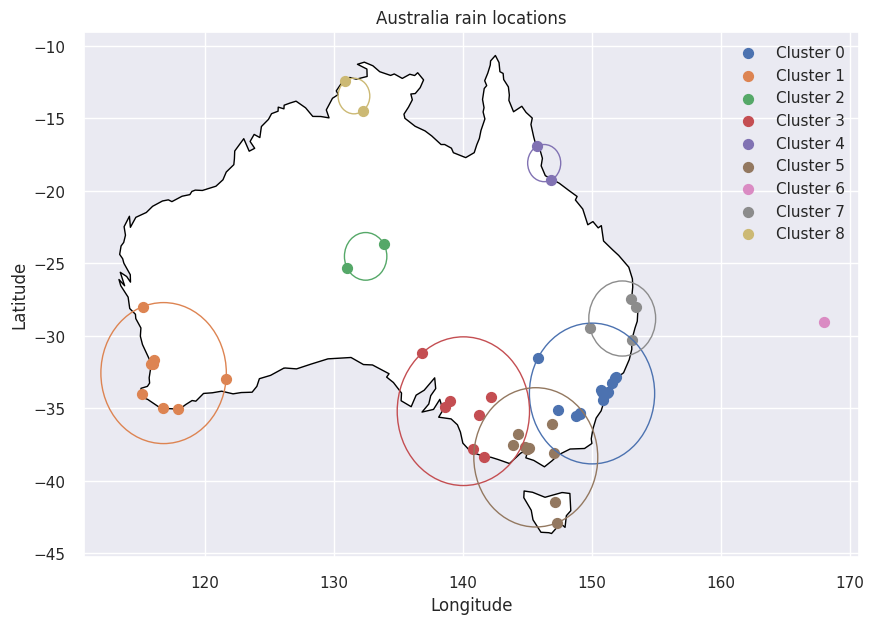

In [276]:
# draws the clustered locations on map

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

fig, gax = plt.subplots(figsize=(10,10))
world.query("name == 'Australia'").plot(ax=gax, edgecolor='black',color='white')

colors = sns.color_palette()

# Plot the locations colored by cluster
for i in range(k):
    plt.scatter(X[kmeans.labels_ == i, 1], X[kmeans.labels_ == i, 0], s=50, c=colors[i], label=f"Cluster {i}")

# Plot the boundaries of clusters
for i in range(k):
    cluster_center = kmeans.cluster_centers_[i]
    cluster_radius = np.max(np.linalg.norm(X[kmeans.labels_ == i] - cluster_center, axis=1))
    circle = plt.Circle((cluster_center[1], cluster_center[0]), cluster_radius, color=colors[i], fill=False)
    plt.gcf().gca().add_artist(circle)

gax.set_title('Australia rain locations')
gax.set_xlabel('Longitude')
gax.set_ylabel('Latitude')
plt.legend()
plt.show()

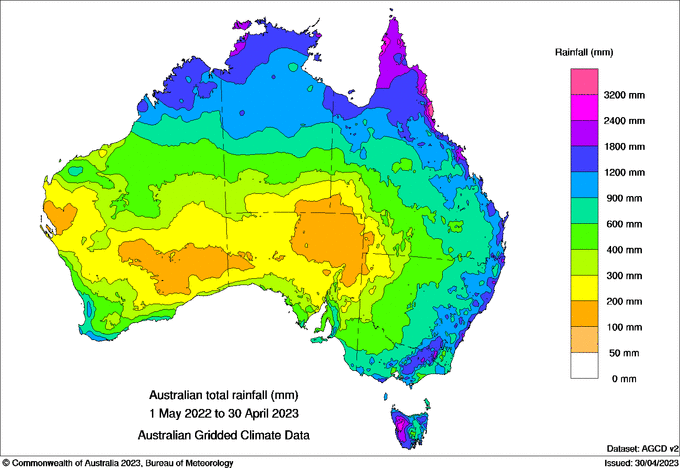

In [277]:
display(Image(filename='data/rainfall_map_australia.png'))

In [278]:
# add new cluster feature to dataset

location_to_cluster = {
    location: cluster for cluster, location in gdf[["Cluster", "Location"]].values
}

locations = df["Location"].copy(deep=True)

df["Cluster"] = np.vectorize(lambda x: location_to_cluster[x])(locations)

Text(0.5, 1.0, 'Distribution of precipitation for each cluster')

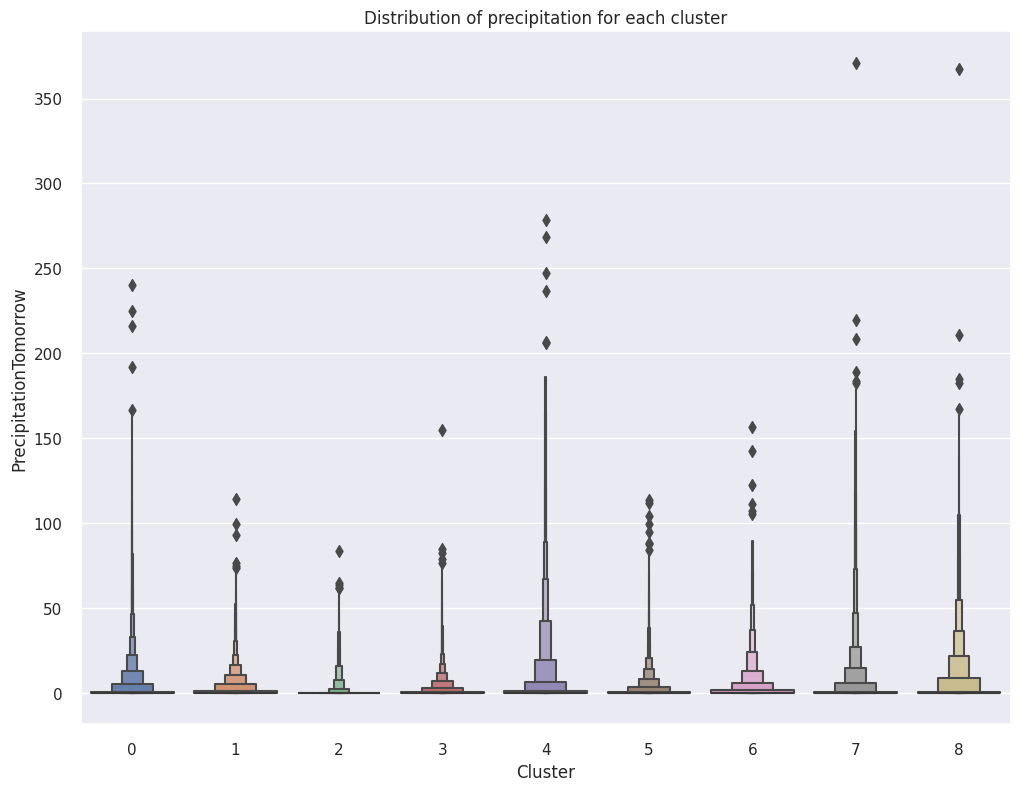

In [279]:
# checking whether each cluster has a different distribution

sns.boxenplot(x=df["Cluster"], y=df["PrecipitationTomorrow"])
plt.title("Distribution of precipitation for each cluster")

In [280]:
# Retype object columns to category type

object_cols = df.select_dtypes("object").columns
df[object_cols] = df[object_cols].astype("category")

df['Cluster'] = df['Cluster'].astype("category")

In [281]:
# Drop columns that aren't needed
# dropping 'Date' since we have extracted the month information
# dropping 'RainTomorrow' to prevent data leakage
# dropping 'RainToday' since it's calculated from `PrecipitationToday`
not_needed = ['Date', 'RainTomorrow', 'RainToday']
df.drop(not_needed, axis=1, inplace=True)

# Drop columns with too many missing values
# Sunshine              47.74%
# Evaporation           42.84%
# Cloud3pm              40.19%
# Cloud9am              37.77%
too_many_missing = ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']
df.drop(too_many_missing, axis=1, inplace=True)

# Drop location column
# We have already extracted the location information into the cluster column
# We can drop the location column since it's not needed anymore
df.drop(['Location'], axis=1, inplace=True)

In [282]:
# train/test split

# using the same seed that was used in EDA notebook
train, test = train_test_split(df, test_size=0.2, random_state=0)

train_X, train_y = train.drop(["PrecipitationTomorrow"], axis=1), train["PrecipitationTomorrow"]
test_X, test_y = test.drop(["PrecipitationTomorrow"], axis=1), test["PrecipitationTomorrow"]

### Wind direction transformer

Each of the features `WindGustDir`, `WindDir9am`, and `WindDir3pm` had too many categorial values (16). We needed to reduce the amount of categorial values to reduce over-fitting. This was done by converting the directions into floats which represented the angle of the direction.

We got this idea from [research paper](https://www.researchgate.net/publication/359513858_Prediction_of_Rainfall_in_Australia_Using_Machine_Learning): 
_Cabezuelo, Antonio. (2022). Prediction of Rainfall in Australia Using Machine Learning. Information. 13. 163. 10.3390/info13040163._ 

In [283]:
def wind_dir_to_degrees(wind_dir):
    if wind_dir == "N":
        return 0
    if wind_dir == "NNE":
        return 25
    if wind_dir == "NE":
        return 45
    if wind_dir == "ENE":
        return 65
    if wind_dir == "ESE":
        return 115
    if wind_dir == "SE":
        return 135
    if wind_dir == "SSE":
        return 155
    if wind_dir == "S":
        return 180
    if wind_dir == "SSW":
        return 205
    if wind_dir == "SW":
        return 225
    if wind_dir == "WSW":
        return 245
    if wind_dir == "WNW":
        return 295
    if wind_dir == "NW":
        return 315
    if wind_dir == "NNW":
        return 335

    # Value for direction W.
    # W is most_frequent so we impute it as well for the missing values.
    return 270


def get_cos_from_wind_dir(wind_dir):
    degrees = wind_dir_to_degrees(wind_dir)
    return cos(radians(degrees))


def get_sin_from_wind_dir(wind_dir):
    degrees = wind_dir_to_degrees(wind_dir)
    return sin(radians(degrees))


def WindDir_To_Sin_Cos_Converter_func(data):
    features = ["WindGustDir", "WindDir9am", "WindDir3pm"]

    for item in features:
        data[f"{item}_Sin"] = data[item].apply(
            lambda value: get_sin_from_wind_dir(value)
        )
        data[f"{item}_Cos"] = data[item].apply(
            lambda value: get_cos_from_wind_dir(value)
        )

    return data.drop(features, axis=1)


# transformer that is used in the final preprocessing pipeline
WindDir_To_Sin_Cos_Converter = FunctionTransformer(WindDir_To_Sin_Cos_Converter_func)


### Outlier remover

As visualized in the exploratory data analysis, the features contain many outliers. To prevent the models from over-fitting the outlier data, we remove the outliers with a IQR remover. We also tried using a ZScore remover, however, the results were significantly better for the IQR remover.

In [284]:
exclude_cols = []


def IQR_Outliers(data, features):
    out_indexlist = []

    for col in features:
        # Using nanpercentile instead of percentile because of nan values
        Q1 = np.nanpercentile(data[col], 25.0)
        Q3 = np.nanpercentile(data[col], 75.0)

        cut_off = (Q3 - Q1) * 1.5
        upper, lower = Q3 + cut_off, Q1 - cut_off

        outliers_index = data[col][
            (data[col] < lower) | (data[col] > upper)
        ].index.tolist()
        out_indexlist.extend(outliers_index)

    out_indexlist = list(set(out_indexlist))
    out_indexlist.sort()

    return out_indexlist


def IQR_Outliers_Remover_func(data):
    numeric_features = data.select_dtypes(include=["float64"]).drop(
        exclude_cols, axis=1
    )
    outliers = IQR_Outliers(data, numeric_features.columns)

    return data.drop(outliers)


def IQR_Outliers_rows(data):
    numeric_features = data.select_dtypes(include=["float64"]).drop(
        exclude_cols, axis=1
    )
    return IQR_Outliers(data, numeric_features.columns)


# transformer that is used in the final preprocessing pipeline
IQR_Outliers_Remover = FunctionTransformer(IQR_Outliers_Remover_func)


In [285]:
def ZScore_Outliers (data, features):
    out_indexlist = []

    for col in features:
        upper_limit = data[col].mean() + 3 * data[col].std()
        lower_limit = data[col].mean() - 3 * data[col].std()
                
        outliers_index = data[col][(data[col] < lower_limit) | (data[col] > upper_limit)].index.tolist()
        out_indexlist.extend(outliers_index)

    out_indexlist = list(set(out_indexlist))
    out_indexlist.sort()

    return out_indexlist

def ZScore_Outliers_Remover_func(data):
    numeric_features = data.select_dtypes(include=["float64"])
    outliers = ZScore_Outliers(data, numeric_features.columns)

    return data.drop(outliers)

ZScore_Outliers_Remover = FunctionTransformer(ZScore_Outliers_Remover_func)

def ZScore_Outliers_rows(data):
    numeric_features = data.select_dtypes(include=["float64"])
    return ZScore_Outliers(data, numeric_features.columns)

In [286]:
numeric_features = [
    'MinTemp', 'MaxTemp',
    'PrecipitationToday',
    'WindGustSpeed',
    'WindSpeed9am', 'WindSpeed3pm',
    'Humidity9am', 'Humidity3pm',
    'Pressure9am', 'Pressure3pm', 
    'Temp9am', 'Temp3pm',
    'WindGustDir_Sin', 'WindGustDir_Cos',
    'WindDir9am_Sin', 'WindDir9am_Cos',
    'WindDir3pm_Sin', 'WindDir3pm_Cos'
]

In [287]:
categorical_features = [
    'Month',
    'Cluster',
]

### Categorical features

We first impute the missing values with most_frequent categories. Then we one-hot encode the categories so we can represent them numerically.

In [288]:
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

### Numerical features

We first impute the missing values with averages. We also tried KNN and Iterative imputer for this purpose, however, they didn't improve the score of the model. Therefore, we decided to only use the Simple imputer since it is the fastest to compute.

Then we normalize the values with StandartScaler.

In [289]:
# simple impute pipeline

numeric_transformer_simple_impute = Pipeline(
    steps=[
        ("imputer", SimpleImputer(missing_values=np.NaN, strategy='mean')), 
        ("scaler", StandardScaler())
    ]
)

pipe_simple_impute = Pipeline(
    steps=[
        ('windir_converter', WindDir_To_Sin_Cos_Converter),
        ("outlier_remover", IQR_Outliers_Remover),
        # ("outlier_remover", ZScore_Outliers_Remover),
        ("inputer_scaler_encoder", ColumnTransformer(
            transformers=[
                ("num", numeric_transformer_simple_impute, numeric_features),
                ("cat", categorical_transformer, categorical_features),
            ]
        )),
    ]
)

pipe_simple_impute

Pipeline(steps=[('windir_converter',
                 FunctionTransformer(func=<function WindDir_To_Sin_Cos_Converter_func at 0x7f1a57f65900>)),
                ('outlier_remover',
                 FunctionTransformer(func=<function IQR_Outliers_Remover_func at 0x7f19f5b96c20>)),
                ('inputer_scaler_encoder',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardSc...
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Pressure3pm',
                                                   'Temp9am', 'Temp3pm',
                                                   'WindGustDir_Sin',
                                                   'WindGustDir_Cos',
                                                   'WindDir9am_Sin',
                                                   'WindDir9am_Cos',
                                                   'WindDir3pm_Sin',
                                                   'WindDir3pm_Cos']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Month', 'Cluster'])]))])

In [290]:
# knn impute pipeline

numeric_transformer_knn_impute = Pipeline(
    steps=[
        ("imputer", KNNImputer(missing_values=np.NaN, n_neighbors=5)), 
        ("scaler", StandardScaler())
    ]
)

pipe_knn_impute = Pipeline(
    steps=[
        ('windir_converter', WindDir_To_Sin_Cos_Converter),
        ("outlier_remover", IQR_Outliers_Remover),
        # ("outlier_remover", ZScore_Outliers_Remover),
        ("inputer_scaler_encoder", ColumnTransformer(
            transformers=[
                ("num", numeric_transformer_knn_impute, numeric_features),
                ("cat", categorical_transformer, categorical_features),
            ]
        )),
    ]
)

In [291]:
# iterative impute pipeline

numeric_transformer_iterative_impute = Pipeline(
    steps=[
        ("imputer", IterativeImputer(missing_values=np.NaN, initial_strategy='mean')), 
        ("scaler", StandardScaler())
    ]
)

pipe_iterative_impute = Pipeline(
    steps=[
        ('windir_converter', WindDir_To_Sin_Cos_Converter),
        ("outlier_remover", IQR_Outliers_Remover),
        # ("outlier_remover", ZScore_Outliers_Remover),
        ("inputer_scaler_encoder", ColumnTransformer(
            transformers=[
                ("num", numeric_transformer_iterative_impute, numeric_features),
                ("cat", categorical_transformer, categorical_features),
            ]
        )),
    ]
)

In [292]:
# Remove outlier rows from labels as well
# IQR method
train_y = train_y.drop(IQR_Outliers_rows(train_X))
test_y = test_y.drop(IQR_Outliers_rows(test_X))

# ZScore method
# train_y = train_y.drop(ZScore_Outliers_rows(train_X))
# test_y = test_y.drop(ZScore_Outliers_rows(test_X))

In [293]:
transformed_simple_impute_train_X = pipe_simple_impute.fit_transform(train_X)
transformed_simple_impute_test_X = pipe_simple_impute.fit_transform(test_X)

assert transformed_simple_impute_train_X.shape[0] == train_y.shape[0]
assert transformed_simple_impute_test_X.shape[0] == test_y.shape[0]

In [294]:
transformed_knn_impute_train_X = pipe_knn_impute.fit_transform(train_X)
transformed_knn_impute_test_X = pipe_knn_impute.fit_transform(test_X)

assert transformed_knn_impute_train_X.shape[0] == train_y.shape[0]
assert transformed_knn_impute_test_X.shape[0] == test_y.shape[0]

In [295]:
transformed_iterative_impute_train_X = pipe_iterative_impute.fit_transform(train_X)
transformed_iterative_impute_test_X = pipe_iterative_impute.fit_transform(test_X)

assert transformed_iterative_impute_train_X.shape[0] == train_y.shape[0]
assert transformed_iterative_impute_test_X.shape[0] == test_y.shape[0]

/home/ubuntu/ml/venv/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/ubuntu/ml/venv/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## Saving the preprocessed data

In order for the preprocessed data to be accessible for each model in separate notebooks, we needed to output the data into files. Since the preprocessed data is a numpy array, we selected the [NPY format](https://numpy.org/doc/stable/reference/generated/numpy.lib.format.html#module-numpy.lib.format), which is an efficient format for storing and loading numpy arrays.

We store the learning feature dataset for each pipeline into a separate file. The target feature data set needs to be stored once.

In [296]:
# ! Uncomment to regenerate data

np.save('data/simple_impute_train_X.npy', transformed_simple_impute_train_X)
np.save('data/simple_impute_test_X.npy', transformed_simple_impute_test_X)

np.save('data/knn_impute_train_X.npy', transformed_knn_impute_train_X)
np.save('data/knn_impute_test_X.npy', transformed_knn_impute_test_X)

np.save('data/iterative_impute_train_X.npy', transformed_iterative_impute_train_X)
np.save('data/iterative_impute_test_X.npy', transformed_iterative_impute_test_X)

np.save('data/train_y.npy', train_y)
np.save('data/test_y.npy', test_y)

# Models

## Evaluation of model performance

We test the models on the test set and using cross validation. We use the following scoring metrics to evaluate the performance of the models: RMSE, R2, and MAE.

The **mean squared error (MSE)** is a measure of the average squared difference between the predicted and actual values. It is a common metric used in regression tasks. The lower the MSE, the better the model is performing. In our case, we use RMSE instead of MSE, because it is easier to interpret. The RMSE is simply the square root of the MSE.

The **R2 score** is a measure of how well the model fits the data. It is a value between 0 and 1, where 1 indicates a perfect fit and 0 indicates no fit at all. The higher the R2 score, the better the model is performing.

The **mean absolute error (MAE)** is a measure of the average absolute difference between the predicted and actual values. It is a common metric used in regression tasks. The lower the MAE, the better the model is performing.

To evaluate the models by the scoring metrics described above, we use the following function. We cross-validate the model and also the baseline dummy model. We also calculate the prediction results on the test set.

In [317]:
def cv_scores(model, model_name, X, y, cv=10):
    dummy = DummyRegressor(strategy="mean")

    dummy_scores_rmse = cross_val_score(dummy, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1)
    model_scores_rmse = cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1)

    dummy_scores_mae = cross_val_score(dummy, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)
    model_scores_mae = cross_val_score(model, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)

    dummy_scores_r2 = cross_val_score(dummy, X, y, cv=cv, scoring="r2", n_jobs=-1)
    model_scores_r2 = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1)

    print("CV scores\n")
    print(f"Dummy RMSE: {-dummy_scores_rmse.mean():>10.2f} (+/- {dummy_scores_rmse.std():.2f})")
    print(f"{model_name} RMSE: {-model_scores_rmse.mean():>10.2f} (+/- {model_scores_rmse.std():.2f})")
    print()
    print(f"Dummy MAE: {-dummy_scores_mae.mean():>10.2f} (+/- {dummy_scores_mae.std():.2f})")
    print(f"{model_name} MAE: {-model_scores_mae.mean():>10.2f} (+/- {model_scores_mae.std():.2f})")
    print()
    print(f"Dummy R2: {dummy_scores_r2.mean():>10.2f} (+/- {dummy_scores_r2.std():.2f})")
    print(f"{model_name} R2: {model_scores_r2.mean():>10.2f} (+/- {model_scores_r2.std():.2f})")


def get_model_pred_score(model, X_train, y_train, X_test, y_test, scoring_metric):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = scoring_metric(y_test, pred)
    return score


def pred_scores(model, model_name, X_train, y_train, X_test, y_test):
    dummy = DummyRegressor(strategy="mean")

    dummy_scores_mse = get_model_pred_score(dummy, X_train, y_train, X_test, y_test, mean_squared_error)
    model_scores_mse = get_model_pred_score(model, X_train, y_train, X_test, y_test, mean_squared_error)

    dummy_scores_mae = get_model_pred_score(dummy, X_train, y_train, X_test, y_test, mean_absolute_error)
    model_scores_mae = get_model_pred_score(model, X_train, y_train, X_test, y_test, mean_absolute_error)

    dummy_scores_r2 = get_model_pred_score(dummy, X_train, y_train, X_test, y_test, r2_score)
    model_scores_r2 = get_model_pred_score(model, X_train, y_train, X_test, y_test, r2_score)

    print("Pred scores\n")
    print(f"Dummy RMSE: {np.sqrt(dummy_scores_mse):.2f}")
    print(f"{model_name} RMSE: {np.sqrt(model_scores_mse):.2f}")
    print()
    print(f"Dummy MAE: {dummy_scores_mae:.2f}")
    print(f"{model_name} MAE: {model_scores_mae:.2f}")
    print()
    print(f"Dummy R2: {dummy_scores_r2:.2f}")
    print(f"{model_name} R2: {model_scores_r2:.2f}")

## Denis - RandomForestRegressor

Random forest regression is an ensemble machine learning algorithm that combines multiple regression trees to make a more accurate prediction. In a random forest regression model, a large number of decision trees are created, each trained on a random subset of the available data, and the average prediction of all the trees is used as the final output. This approach reduces overfitting and increases the accuracy of the model compared to a single regression tree.

In a regression tree, the input data is recursively partitioned into subsets based on the value of the input features, with the goal of minimizing the variance within each subset. At each step, the algorithm selects the feature that provides the best split, based on some criterion such as mean squared error or variance reduction. The process continues until a stopping criterion is met, such as a minimum number of samples in each leaf node.

In [297]:
train_X = np.load('data/simple_impute_train_X.npy')
test_X = np.load('data/simple_impute_test_X.npy')

train_y = np.load('data/train_y.npy')
test_y = np.load('data/test_y.npy')

### Hyperparameter tuning

We try to find the best hyperparamters for the underlying regression tree in the random forest regressor.

In [299]:
regressor = RandomForestRegressor(
    n_estimators=1,
    n_jobs=-1,
)

params = {
    'min_samples_leaf': [220, 250, 280],
    'min_samples_split': [11, 12, 13, 14, 15],
    'max_depth': [23, 24, 25, 26, 27],
    'max_leaf_nodes': [20000, 30000, 40000, 50000],
}

gs = GridSearchCV(regressor, params, cv=10, n_jobs=-1, verbose=1)
gs.fit(train_X, train_y)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(n_estimators=1, n_jobs=-1),
             n_jobs=-1,
             param_grid={'max_depth': [23, 24, 25, 26, 27],
                         'max_leaf_nodes': [20000, 30000, 40000, 50000],
                         'min_samples_leaf': [220, 250, 280],
                         'min_samples_split': [11, 12, 13, 14, 15]},
             verbose=1)

In [300]:
best_params = gs.best_params_
best_params

# best_params = {'max_depth': 24,
#  'max_leaf_nodes': 20000,
#  'min_samples_leaf': 220,
#  'min_samples_split': 12}

{'max_depth': 24,
 'max_leaf_nodes': 20000,
 'min_samples_leaf': 220,
 'min_samples_split': 12}

We try to select a subset of features that perform best with the regression tree.

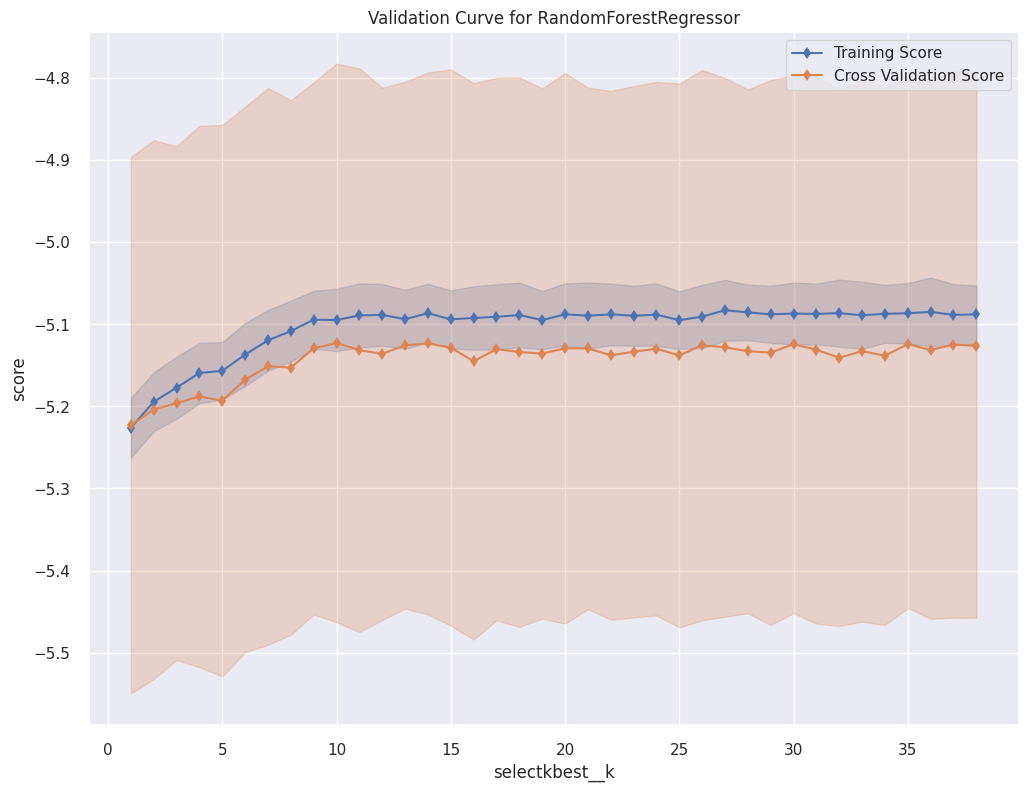

<Axes: title={'center': 'Validation Curve for RandomForestRegressor'}, xlabel='selectkbest__k', ylabel='score'>

In [301]:
pipe = make_pipeline(
    SelectKBest(k=42),
    RandomForestRegressor(
        n_estimators=1,
        n_jobs=-1,
        **best_params
    )
)

viz = ValidationCurve(
    pipe,
    param_name="selectkbest__k",
    param_range=np.arange(1, train_X.shape[1]),
    cv=10,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

# Fit and show the visualizer
viz.fit(train_X, train_y)
viz.show()

In [302]:
best_k = viz.train_scores_.mean(axis=1).argmax() + 1
best_k

# best_k = 27

27

Now with the hyperparameters and K best features we try to find the best number of regression trees used in the random forest regressor.

In [303]:
pipe = make_pipeline(
    SelectKBest(k=best_k),
    RandomForestRegressor(
        n_jobs=-1,
        **best_params
    )
)

params = {
    'randomforestregressor__n_estimators': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

gs = GridSearchCV(pipe, params, cv=10, n_jobs=-1, verbose=1)
gs.fit(train_X, train_y)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('selectkbest', SelectKBest(k=27)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(max_depth=24,
                                                              max_leaf_nodes=20000,
                                                              min_samples_leaf=220,
                                                              min_samples_split=12,
                                                              n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [5, 10, 20, 30,
                                                                 40, 50, 60, 70,
                                                                 80, 90, 100]},
             verbose=1)

In [304]:
best_params = {
    'n_estimators': gs.best_params_['randomforestregressor__n_estimators'],
    **best_params
}
best_params

# best_params = {
#     'n_estimators': 70,
#     'max_depth': 24,
#     'max_leaf_nodes': 20000,
#     'min_samples_leaf': 220,
#     'min_samples_split': 12
# }

{'n_estimators': 70,
 'max_depth': 24,
 'max_leaf_nodes': 20000,
 'min_samples_leaf': 220,
 'min_samples_split': 12}

### The final score

We see that our model performs slightly better than the baseline. We can assume, therefore, that the model gained some knowledge from the data.

In [305]:
pipe = make_pipeline(
    SelectKBest(k=best_k),
    RandomForestRegressor(
        **best_params,
        n_jobs=-1
    )
)

cv_scores(pipe, "RFR", train_X, train_y)
print(f"\n{'-' * 30}\n")
pred_scores(pipe, "RFR", train_X, train_y, test_X, test_y)

CV scores

Dummy RMSE:       5.55 (+/- 0.33)
RFR RMSE:       5.05 (+/- 0.34)

Dummy MAE:       2.27 (+/- 0.03)
RFR MAE:       1.77 (+/- 0.05)

Dummy R2:      -0.00 (+/- 0.00)
RFR R2:       0.17 (+/- 0.02)

------------------------------

Pred scores

Dummy RMSE: 5.26
RFR RMSE: 4.78

Dummy MAE: 2.25
RFR MAE: 1.78

Dummy R2: -0.00
RFR R2: 0.18


## Honza - KNN Regressor

K-Nearest Neighbors (KNN) Regressor is a type of regression algorithm used in machine learning for predicting continuous numerical values. It is a non-parametric algorithm that works by finding the K closest neighbors to a given data point and then takes the average of the target values of those neighbors to make a prediction for the new data point.

The "K" in KNN Regressor refers to the number of neighbors that the algorithm considers when making a prediction. The optimal value for K is typically found through experimentation and can vary depending on the specific dataset and problem.

To make a prediction using KNN Regressor, the algorithm calculates the distance between the new data point and each of the training data points in the dataset. The distance metric used can vary, but commonly used metrics include Euclidean distance and Manhattan distance. The K closest neighbors to the new data point are then selected, and the average of their target values is used to make the prediction.


In [306]:
train_X = np.load('data/simple_impute_train_X.npy')
test_X = np.load('data/simple_impute_test_X.npy')

transformed_knn_impute_train_X = np.load('data/knn_impute_train_X.npy')
transformed_knn_impute_test_X = np.load('data/knn_impute_test_X.npy')

train_y = np.load('data/train_y.npy')
test_y = np.load('data/test_y.npy')

Finding the best models.

In [307]:
regressor = KNeighborsRegressor()

parameters = {
    "n_neighbors": [1, 5, 10, 20, 30, 40, 50],
    "algorithm": ["auto", "ball_tree", "kd_tree"],
}

grid_search = GridSearchCV(regressor, parameters, n_jobs=-1)
grid_search.fit(train_X, train_y)

{'algorithm': 'kd_tree', 'n_neighbors': 20}


In [310]:
best_params = grid_search.best_params_
best_params

# best_params = {
#     n_neighbors=20,
#     algorithm="kd_tree"
# }

{'algorithm': 'kd_tree', 'n_neighbors': 20}

Finding the best number of features.

In [311]:
k_values = np.arange(1, 33, 1)

mean_scores = []
std_scores = []

for k in k_values:
    selector = SelectKBest(k=k)
    
    X_selected = selector.fit_transform(train_X, train_y)
    
    reg = KNeighborsRegressor(**best_params)
    
    cv_r2 = cross_val_score(reg, X_selected, train_y, cv=5, scoring='r2', n_jobs=-1)
    
    mean_scores.append(np.mean(cv_r2))
    std_scores.append(np.std(cv_r2))

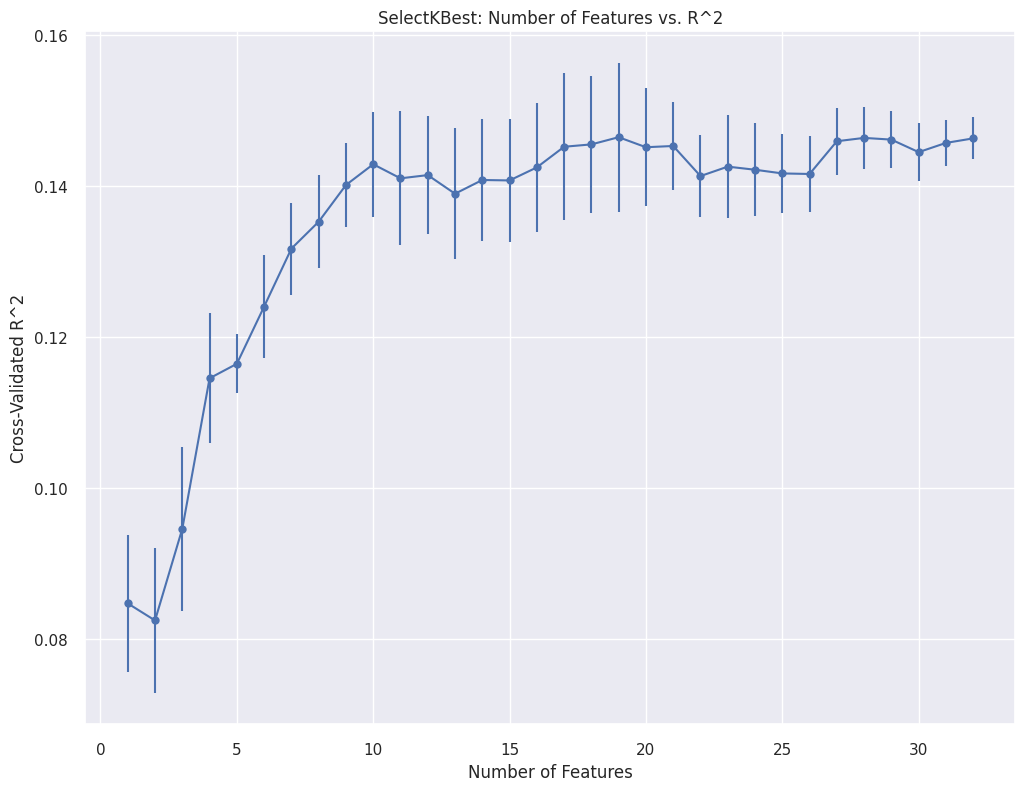

In [312]:
plt.errorbar(k_values, mean_scores, yerr=std_scores, fmt='o-', capsize=5)

plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated R^2')
plt.title('SelectKBest: Number of Features vs. R^2')

plt.show()

In [313]:
optimal_number_of_features = mean_scores.index(max(mean_scores))
print("{}: {}".format("optimal_number_of_features", optimal_number_of_features))

optimal_number_of_features: 18


In [314]:
knn_regressor = make_pipeline(
    SelectKBest(k=optimal_number_of_features),
    KNeighborsRegressor(**best_params)
)

cv_scores(knn_regressor, "KNN_R", train_X, train_y)
print(f"\n{'-' * 30}\n")
pred_scores(knn_regressor, "KNN_R", train_X, train_y, test_X, test_y)

CV scores

Dummy RMSE:       5.55 (+/- 0.33)
KNN_R RMSE:       5.13 (+/- 0.32)

Dummy MAE:       2.27 (+/- 0.03)
KNN_R MAE:       1.66 (+/- 0.04)

Dummy R2:      -0.00 (+/- 0.00)
KNN_R R2:       0.15 (+/- 0.02)

------------------------------

Pred scores

Dummy RMSE: 5.26
KNN_R RMSE: 4.86

Dummy MAE: 2.25
KNN_R MAE: 1.67

Dummy R2: -0.00
KNN_R R2: 0.15


Model tried on data where Knn Imputer was used.

In [315]:
cv_scores(knn_regressor, "KNN_R", transformed_knn_impute_train_X, train_y)
print(f"\n{'-' * 30}\n")
pred_scores(knn_regressor, "KNN_R", transformed_knn_impute_train_X, train_y, transformed_knn_impute_test_X, test_y)

CV scores

Dummy RMSE:       5.55 (+/- 0.33)
KNN_R RMSE:       5.13 (+/- 0.33)

Dummy MAE:       2.27 (+/- 0.03)
KNN_R MAE:       1.66 (+/- 0.04)

Dummy R2:      -0.00 (+/- 0.00)
KNN_R R2:       0.15 (+/- 0.02)

------------------------------

Pred scores

Dummy RMSE: 5.26
KNN_R RMSE: 4.88

Dummy MAE: 2.25
KNN_R MAE: 1.67

Dummy R2: -0.00
KNN_R R2: 0.14


Since knn regressor is better on lower dimensionality data I tried to use less number of dimensions.

In [316]:
knn_regressor_less_feature = make_pipeline(
    SelectKBest(k=20),
    KNeighborsRegressor(**best_params)
)

cv_scores(knn_regressor_less_feature, "KNN_R", train_X, train_y)
print(f"\n{'-' * 30}\n")
pred_scores(knn_regressor_less_feature, "KNN_R", train_X, train_y, test_X, test_y)

CV scores

Dummy RMSE:       5.55 (+/- 0.33)
KNN_R RMSE:       5.13 (+/- 0.33)

Dummy MAE:       2.27 (+/- 0.03)
KNN_R MAE:       1.65 (+/- 0.04)

Dummy R2:      -0.00 (+/- 0.00)
KNN_R R2:       0.15 (+/- 0.02)

------------------------------

Pred scores

Dummy RMSE: 5.26
KNN_R RMSE: 4.86

Dummy MAE: 2.25
KNN_R MAE: 1.65

Dummy R2: -0.00
KNN_R R2: 0.15


## Dominik - XGBoost Regressor

XGBoost is an optimized distributed gradient boosting library used for regression and classification tasks. It is based on the concept of gradient boosting, where weak learners are iteratively added to the model to create a strong predictive model. Each weak learner is trained on the residuals of the previous learner to correct the errors made by the previous learner. The final model is a weighted sum of all the weak learners.

XGBoost uses decision trees as weak learners and L1 and L2 regularization to prevent overfitting and improve the generalization of the model. It also uses gradient descent optimization to minimize the loss function and improve the accuracy of the model. Additionally, XGBoost prunes the decision trees during the training process to avoid overfitting and improve the performance of the model. It is designed to handle large datasets and can take advantage of parallel processing to speed up the training process within a single decision tree to create branches independently.

In [318]:
train_X = np.load('data/simple_impute_train_X.npy')
test_X = np.load('data/simple_impute_test_X.npy')

train_y = np.load('data/train_y.npy')
test_y = np.load('data/test_y.npy')

In order to make our results reproducible, we made sure to use random seeds.

In [319]:
# cross validation for hyperparameter tuning

cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=0,  # for reproducibility
)

For hyperparameter tuning we are using [Hyperopt](https://github.com/hyperopt/hyperopt). Hyperopt is a Python library for hyperparameter optimization. The main goal of Hyperopt is to minimize the amount of time and computational resources required to find the best hyperparameters by intelligently exploring the hyperparameter space. It achieves this through a technique called sequential model-based optimization (SMBO), which involves constructing a probabilistic model of the hyperparameter space and using it to guide the search for promising regions. This was crucial for us, because we had a lot of hyperparameters to tune and we wanted to find the best combination of them.





Hyperopt allows you to define the search space for hyperparameters using a domain space object. It supports various types of hyperparameters such as real values, integer values, and categorical values.

In [320]:
# hyperparameter search space

space = {
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'max_depth': hp.choice('max_depth', range(3, 21, 2)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.quniform('reg_alpha', 1, 100, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'max_delta_step': hp.quniform('max_delta_step', 1, 10, 1),
}

We define an objective function that takes a set of hyperparameters as input and returns a scalar value that represents the performance of the model using those hyperparameters. The objective function is what Hyperopt tries to optimize. The objective function uses 5-fold cross-validation to evaluate the performance of the model. The use of the cross-validation technique ensures that the model is not overfitting the training data and is able to generalize well to unseen data. The objective function returns the mean squared error (MSE) of the model on the validation set.

In [321]:
def objective(params, cv=cv, train_X=train_X, train_y=train_y):
    model = xgb.XGBRegressor(
        **params,
        n_jobs=-1,
        seed=0  # for reproducibility
    )
    loss = -1 * cross_val_score(
        estimator=model,
        X=train_X,
        y=train_y,
        cv=cv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    ).mean()

    return {
        'loss': loss,
        'params': params,
        'status': STATUS_OK
    }

Hyperopt keeps track of the evaluations of different hyperparameter configurations through a trials object. It stores the hyperparameters and the corresponding objective function values for each evaluation.  

In [322]:
trials = Trials()

Hyperopt provides several optimization algorithms, including Random Search, **Tree of Parzen Estimators (TPE)**, and Adaptive TPE. These algorithms explore the hyperparameter space in different ways to find the best configuration. We use TPE, because it's the default algorithm and often yields good results with limited evaluations.

To start the optimization process, we call the `fmin` function and pass it the objective function, domain space, the chosen optimization algorithm, the trials object, and lastly the amount of iterations. Hyperopt then iteratively suggests new hyperparameter configurations to evaluate based on the previous trials and the probabilistic models it builds

In [ ]:
# 'fmin' function minimizes the loss
# 'objective' function is the function to minimize
# 'trials' is the object that holds all the information from the search
# 'tpe.suggest' is the algorithm used to perform the search
# 'max_evals' is the number of iterations to perform the search
# 'space' is the search space defined above

best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=100,
)
best_params

100%|██████████| 100/100 [2:45:33<00:00, 99.33s/trial, best loss: 4.8134290864118885]  


{'colsample_bytree': 0.6629652251686992,
 'gamma': 3.6261143152581665,
 'learning_rate': 0.0231736018230995,
 'max_delta_step': 7.0,
 'max_depth': 4,
 'min_child_weight': 2.0,
 'n_estimators': 864,
 'reg_alpha': 65.0,
 'reg_lambda': 1.3380522001048525,
 'subsample': 0.800579605490957}

In [324]:
# these are the best parameters found by the hyperopt search

best_params = {
    'colsample_bytree': 0.6629652251686992,
    'gamma': 3.6261143152581665,
    'learning_rate': 0.0231736018230995,
    'max_delta_step': 7.0,
    'max_depth': 4,
    'min_child_weight': 2.0,
    'n_estimators': 864,
    'reg_alpha': 65.0,
    'reg_lambda': 1.3380522001048525,
    'subsample': 0.800579605490957
}

In [326]:
model = xgb.XGBRegressor(
    **best_params,
    n_jobs=-1,
)

cv_scores(model, "XGBoost", train_X, train_y)
print(f"\n{'-' * 30}\n")
pred_scores(model, "XGBoost", train_X, train_y, test_X, test_y)

CV scores

Dummy RMSE:       5.55 (+/- 0.33)
XGBoost RMSE:       4.91 (+/- 0.32)

Dummy MAE:       2.27 (+/- 0.03)
XGBoost MAE:       1.74 (+/- 0.04)

Dummy R2:      -0.00 (+/- 0.00)
XGBoost R2:       0.22 (+/- 0.02)

------------------------------

Pred scores

Dummy RMSE: 5.26
XGBoost RMSE: 4.65

Dummy MAE: 2.25
XGBoost MAE: 1.75

Dummy R2: -0.00
XGBoost R2: 0.22


This XGBoost Regressor model has a RMSE score of `4.85` on the test set and `4.84` on the cross validation set. This is not a significant improvement over the baseline model. The MAE score is less sensitive to outliers than the RMSE score, so we can see that the model is performing better with this metric. The R2 score of this model is `0.91`, which is a very poor score, indicating that the model didn't fit the data well.

We can plot the importance (weight) of each feature in the prediction using the `feature_importances_` attribute provided by XGBoost. This allows us to see which features are the most important for the model and which features can be removed to improve the performance of the model.

In [327]:
feature_names = pipe_simple_impute['inputer_scaler_encoder'].transformers_[0][1].get_feature_names_out().tolist()
feature_names += pipe_simple_impute['inputer_scaler_encoder'].transformers_[1][1]['encoder'].get_feature_names_out().tolist()

def plot_feature_importance(model):
    feature_importance = pd.DataFrame(
        data=model.feature_importances_,
        columns=["Importance"],
        index=feature_names,
    ).sort_values(by="Importance", ascending=False)
    sns.barplot(
        x="Importance",
        y=feature_importance.index,
        data=feature_importance,
        order=feature_importance.index,
        orient="h",
    )
    plt.title("Feature Importance")

feature_names

['MinTemp',
 'MaxTemp',
 'PrecipitationToday',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm',
 'WindGustDir_Sin',
 'WindGustDir_Cos',
 'WindDir9am_Sin',
 'WindDir9am_Cos',
 'WindDir3pm_Sin',
 'WindDir3pm_Cos',
 'x0_April',
 'x0_August',
 'x0_December',
 'x0_February',
 'x0_January',
 'x0_July',
 'x0_June',
 'x0_March',
 'x0_May',
 'x0_November',
 'x0_October',
 'x0_September',
 'x1_0',
 'x1_1',
 'x1_2',
 'x1_3',
 'x1_4',
 'x1_5',
 'x1_6',
 'x1_7',
 'x1_8']

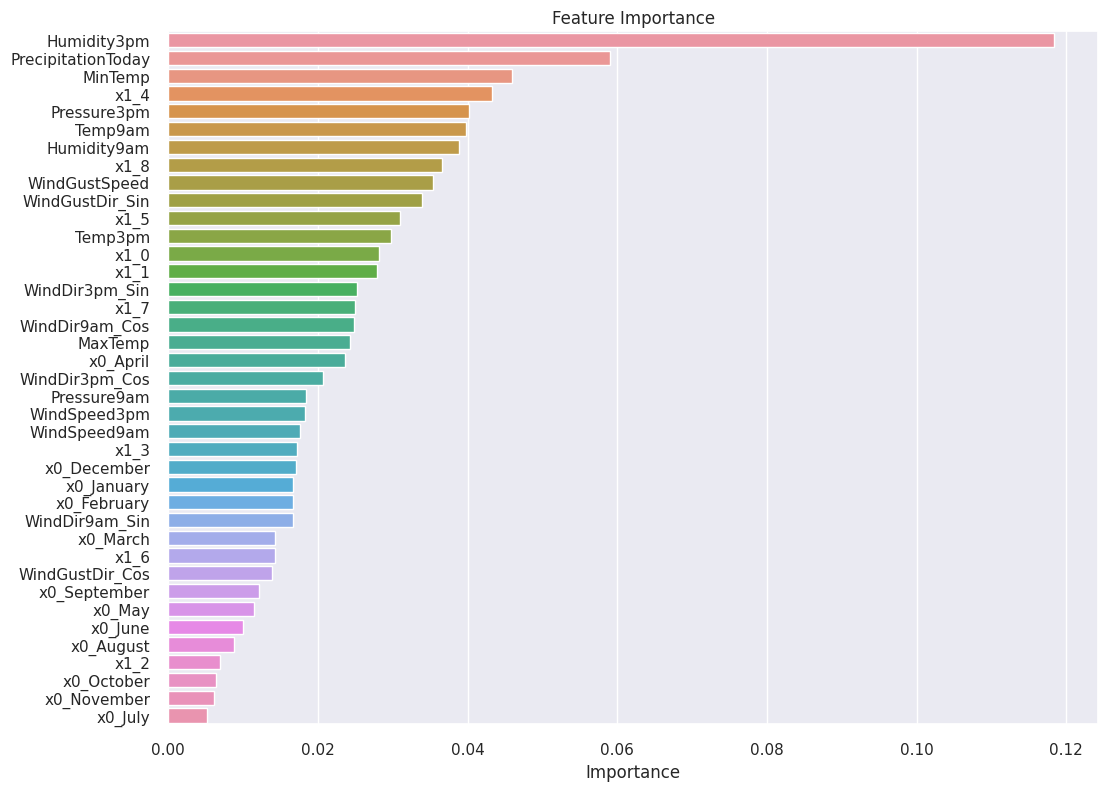

In [328]:
plot_feature_importance(model)

The graph above clearly shows that there is an uneven distribution of importance among the features. The most important features are `Humidity3pm` and `PrecipitationToday`. From the graph we can also see that the importance of the features decreases as we move down the graph. Some features have a very low importance, which means that they are not very useful for the model. We will therefore try to remove the least important features and see if the performance of the model improves.

In [329]:
thresholds = np.sort(model.feature_importances_)

scores = []
best_score = np.inf
best_selection = None

for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(train_X)
    select_X_test = selection.transform(test_X)
    
    score = objective(best_params, train_X=select_X_train, train_y=train_y)['loss']
    scores.append(score)

    if score < best_score:
        best_score = score
        best_selection = selection

In [335]:
best_selection.transform(train_X).shape

(88561, 26)

In [337]:
thresholds[scores.index(best_score)]

0.01672151

The following graph shows the performance of the model with different amounts of features removed according to their importance thresholds. 

Text(0, 0.5, 'Score')

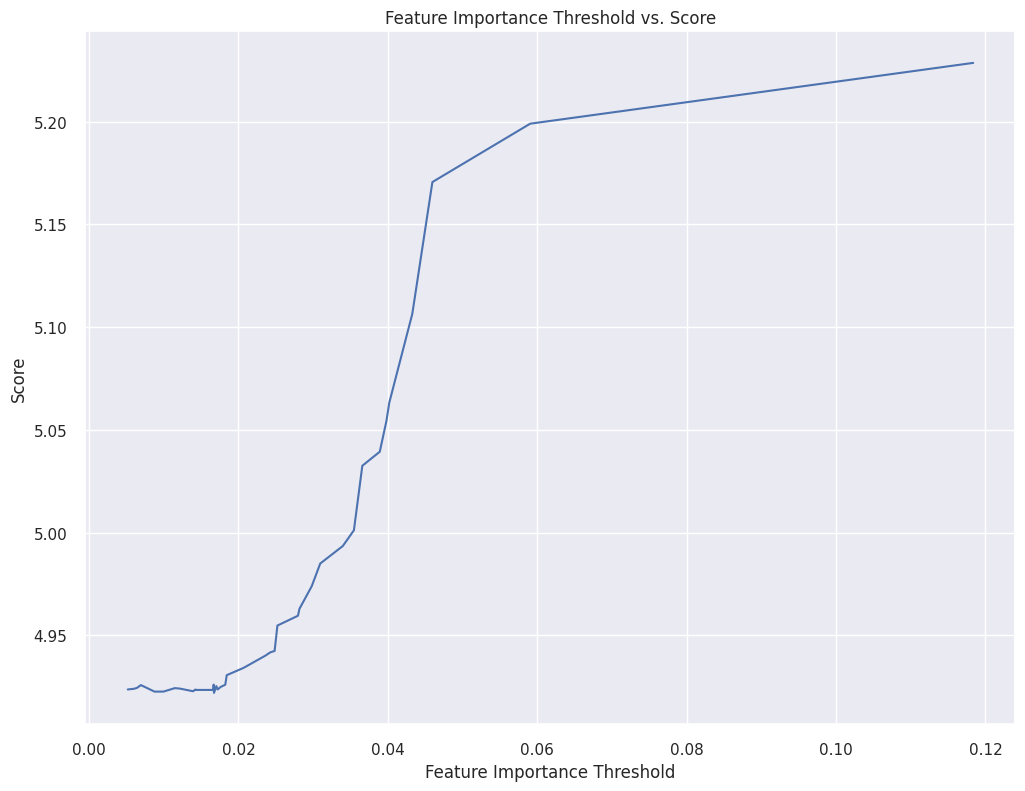

In [330]:
sns.lineplot(x=thresholds, y=scores)

plt.title("Feature Importance Threshold vs. Score")
plt.xlabel("Feature Importance Threshold")
plt.ylabel("Score")

As we can see in the graph above, the performance of the model improves when we remove the least important features, however, it starts to decrease again when we remove too many features. The best performance is achieved when we remove the features with an importance threshold of `0.016`. That leaves us with 26 features, which is a significant reduction from the original 39 features.

In [331]:
select_X_train = best_selection.transform(train_X)
select_X_test = best_selection.transform(test_X)

In [332]:
# test the model with the best feature selection

model = xgb.XGBRegressor(
    **best_params,
    n_jobs=-1,
)

cv_scores(model, "XGBoost", select_X_train, train_y)
print(f"\n{'-' * 30}\n")
pred_scores(model, "XGBoost", select_X_train, train_y, select_X_test, test_y)

CV scores

Dummy RMSE:       5.55 (+/- 0.33)
XGBoost RMSE:       4.91 (+/- 0.31)

Dummy MAE:       2.27 (+/- 0.03)
XGBoost MAE:       1.74 (+/- 0.04)

Dummy R2:      -0.00 (+/- 0.00)
XGBoost R2:       0.22 (+/- 0.02)

------------------------------

Pred scores

Dummy RMSE: 5.26
XGBoost RMSE: 4.64

Dummy MAE: 2.25
XGBoost MAE: 1.74

Dummy R2: -0.00
XGBoost R2: 0.22


The results of the final model is a RMSE score of `4.64` on the test set and `4.91` on the cross validation set. This model therefore performs slightly better on the test set, however, there is not improvement in the cross validation score.

# Conclusion

<img src="data/table.jpg" alt="drawing"/>

As can be seen in the tables above, all models performed better than the dummy model. According to the CV scores, best performing model was the XGBoost regressor, which had the lowest RMSE and MAE scores and the highest R2 score. The KNN Regressor performed the worst out of the three models, but it still performed better than the dummy model. An interesting thing to note is that the XGBoost model performed very well on the test set compared to the cross validation set, which might indicate that the model is overfitting the training data.

One possible explanation for why the XGBoost Regressor performed the best is that it is a more complex model than the other two models. The XGBoost Regressor is an ensemble model, which means that it combines the predictions of several base estimators to improve the performance of the model. The Random Forest Regressor is also an ensemble model, but is far less complex than the XGBoost Regressor. The KNN Regressor is the simplest model out of the three models, which is why it performed the worst.

Another explanation for why the XGBoost Regressor performed the best is that it is a more flexible model than the other two models. The XGBoost Regressor is able to capture more complex relationships between the features and the target variable than the other two models. We also used a different optimization algorithm for the XGBoost Regressor than the other two models, which could have contributed to the better performance of the XGBoost Regressor.

Even though the XGBoost Regressor performed the best according to the CV scores, it was the most complex model out of the three models and used the most complex hyperparameter tuning. This of course implies that training the XGBoost model took a significantly longer time than the other models. The Random Forest Regressor performed almost as well as the XGBoost Regressor, but it was a lot simpler. Therefore, we can conclude that the Random Forest Regressor is the most fitting (not in the literal sense) model for this dataset, because it is simple and performs well.